In [26]:
device = 'cuda'
DEVICE = 'cuda'

# Define the search space

In [1]:
l = 12
g = 6
para_dict = {'l':l,'g':g}
code_class = 'bb'

from code_construction.code_construction import CodeConstructor
code_constructor = CodeConstructor(method=code_class,para_dict = para_dict)

# Define the objective function


In [ ]:
from bayesian_optimization.objective_function import ObjectiveFunction

pp=0.006

# ------depolarizing noise------
# Obj_Func = ObjectiveFunction(code_constructor, pp=pp)
# ------circuit level noise------
Obj_Func = ObjectiveFunction(code_constructor,
                             pp=pp,
                             decoder_param={'trail': 10000,'max_error':100},
                             circuit_level_noise = True,
                             circuit_param={
                                'noise_model':'SD6',
                                'num_workers' : 24,
                                'rounds':12,
                                'custom_error_model':{},
                                'decoder':'bplsd'
                            })


# ------if we use ler function
obj_func = Obj_Func.nller
pl_to_obj = Obj_Func.nlpl_with_std
# if we use lerpq function
# obj_func = Obj_Func.nllerpq
# pl_to_obj = Obj_Func.nllerpq_with_std
# if we use forward function
# obj_func = Obj_Func.forward
# pl_to_obj = Obj_Func.pl_to_obj_with_std



# Initialize the Get_new_points_function 

In [29]:
import numpy as np
import torch
class Get_new_points_function():
    def __init__(self,method='qc-ldpc-hgp',hyperparameters = {'p': 2, 'q': 6, 'm': 2},encode='None'):
        self.method = method
        self.hyperparameters = hyperparameters
        self.encode = encode
        self.init = False

    def get_new_points_function(self,number):
        if self.method == 'qc-ldpc-hgp':
            new_points = self.get_new_points_HGP(number)
        elif self.method == 'bb':
            new_points = self.get_new_bb_vector(number)
        return new_points
        
    def get_new_points_HGP(self,number):
        return np.random.randint(0, self.hyperparameters['m'] + 1, (number, self.hyperparameters['p'] * self.hyperparameters['q']))

    def get_new_bb_vector(self,number):
        results = []
        l = self.hyperparameters['l']
        g = self.hyperparameters['g']
        if self.init == False and l==12 and g==999:
            print('best known bb code added to initial points')
            self.init=True

            a = np.zeros((l+g-1)*2)
            a[3]=1
            a[11+1]=1
            a[11+2]=1
            a[17+1]=1
            a[17+2]=1
            a[17+11+3]=1
            results.append(a)

        while number>0:
            new_point = np.random.randint(0,2, size=(l+g-1)*2)
            c = code_constructor.construct(new_point)
            if c.k==0:
                continue
            else:
                results.append(new_point)
                number -= 1
        return np.array(results)


gnp = Get_new_points_function(method=code_class,hyperparameters = para_dict).get_new_points_function

In [30]:
init_num = 20
X_init = gnp(init_num)
y_init = []
pl_init = []
for x in X_init:
    y,pl = obj_func(x)
    y_init.append(y)
    pl_init.append(pl)

X_init = torch.tensor(X_init,dtype=torch.float32)
X_init.to(DEVICE)
y_init = torch.tensor(y_init,dtype=torch.float32)
y_init.to(DEVICE)
pl_init = torch.tensor(pl_init,dtype=torch.float32)
pl_init.to(DEVICE)

tensor([0.5301, 0.1433, 0.4758, 0.1553, 0.1842, 0.2261, 0.1476, 0.7077, 0.2567,
        0.4345, 0.3065, 0.2032, 0.6829, 0.2447, 0.2757, 0.2973, 0.4243, 0.2770,
        0.2961, 0.2400], device='cuda:0')

# Define the Gaussian Process and it's training process

In [31]:
from bayesian_optimization.encoder import *
from bayesian_optimization.chaincomplexembedding import *
from bayesian_optimization.gp import *
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, MaternKernel, SpectralMixtureKernel, ScaleKernel

class E():
    def __init__(self,code_constructor,views_info ):
        self.code_constructor = code_constructor
        self.encoder = CSSEncoder(views_info,mode ='relations')

    def encode_single(self,x):
        return self.encoder.encode(self.code_constructor.construct(np.array(x).astype(int)))
    def encode(self,x):
        # x: B views
        return [self.encode_single(i) for i in x]
views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
   "weight_mode":"count", "log1p":True},
  {"name":"xlogic",
   "partite_classes":["DQ","SX","LX"],
   "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"],
   "weight_mode":"count", "log1p":True},
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","LZ"],
   "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"],
   "weight_mode":"count", "log1p":True},
]

def get_model_(X, y, kernel_type='ard_rbf', mean_type='linear', mean_input=64,embed_dim=128):

    encoder = E(code_constructor,views_info)

    # NN embedder
    embedding = ChainComplexEmbedder(
        views_info=views_info,
        d_model=embed_dim ,
        num_layers=4,
        view_aggr="sum",
        num_bases=4,
        norm="sym",
        residual=True,
        self_loop=False,
        dropout=0.1,
    ).to(device)



    # kernel
    if kernel_type == 'ard_rbf':
        base = RBFKernel(ard_num_dims=embed_dim)
        kernel = ScaleKernel(base)
    elif kernel_type == 'matern':
        base = MaternKernel(nu=1.5, ard_num_dims=embed_dim)
        kernel = ScaleKernel(base)
    elif kernel_type == 'spectral_mixture':
        kernel = SpectralMixtureKernel(num_mixtures=4, ard_num_dims=embed_dim)
    elif kernel_type == 'rbf_plus_periodic':
        from gpytorch.kernels import PeriodicKernel
        rbf = ScaleKernel(RBFKernel(ard_num_dims=embed_dim))
        periodic = ScaleKernel(PeriodicKernel(ard_num_dims=embed_dim))
        kernel = rbf + periodic
    else:
        kernel = ScaleKernel(RBFKernel())

    # likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # train_x/y to device, y -> 1D for ExactGP
    train_x = X.to(device).float()
    train_y = y.to(device).float().view(-1)

    gp = GaussianProcess_QEC(
        train_x, train_y,
        likelihood=likelihood,
        kernel=kernel,
        encoder=encoder.encode,
        embed=embedding,
        mean=mean_type,
        mean_input=mean_input,
    ).to(device)

    return gp
model = get_model_(
    X_init,
    pl_init,
    kernel_type='matern',
    mean_type='linear',
    mean_input=128,
)

In [ ]:
# gp_trainer.py
import copy
from typing import Dict, Optional, Tuple, Any, List

import torch
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.nn.utils import clip_grad_norm_


class GPTrainer:
    """
    Trainer for an ExactGP with a fixed structure (e.g., ScaleKernel ∘ Matern).

    Public methods:
      - update_data(X, z)            : Hot-update the full training set
                                       (z is the normalized log(pl)).
      - on_normalizer_change(old,new): Rescale outputscale/noise when the scaler std changes.
      - maybe_freeze_unfreeze(round): Optionally freeze lengthscale in early rounds.
      - train_one_round()            : One training round (scheduler/early stop/grad clipping/priors/constraints).
    """

    def __init__(
        self,
        model: gpytorch.models.ExactGP,
        device: str = "cpu",

        training_iter: int = 80,
        lr: Optional[Dict[str, float]] = None,          # {'embed':4e-4,'mean':1e-3,'kernel':1e-3,'like':2e-2}
        weight_decay: float = 1e-4,
        max_grad_norm: float = 2.0,
        optimizer_type: str = "adamw",
        recreate_optimizer_each_round: bool = True,

        scheduler_cfg: Optional[Dict[str, Any]] = None, # {'factor':0.5,'patience':5,'min_lr':1e-6}
        early_stopping: Optional[Dict[str, Any]] = None,# {'patience':10,'tol':1e-4}

        use_priors: bool = True,
        priors_cfg: Optional[Dict[str, Dict[str, float]]] = None,
        noise_floor: float = 1e-3,                      # lower bound (in z-domain) for likelihood noise
        lengthscale_bounds: Optional[Tuple[float, float]] = None,

        warm_start: bool = True,
        rescale_on_scaler_change: bool = True,          # alpha = old_std / new_std
        carry_optimizer_state: bool = False,

        freeze_cfg: Optional[Dict[str, Any]] = None,    # {'lengthscale_until_round': 2}

        verbose: bool = True,
        log_every: Optional[int] = None,
        save_best_state: bool = True,
    ):
        self.model = model.to(device)
        self.device = device

        self.training_iter = int(training_iter)
        self.weight_decay = float(weight_decay)
        self.max_grad_norm = float(max_grad_norm)
        self.optimizer_type = optimizer_type.lower()
        self.recreate_optimizer_each_round = bool(recreate_optimizer_each_round)

        self.scheduler_cfg = scheduler_cfg or {'factor': 0.5, 'patience': 5, 'min_lr': 1e-6}
        self.early_stopping = early_stopping or {'patience': 10, 'tol': 1e-4}

        self.use_priors = bool(use_priors)
        self.priors_cfg = priors_cfg or {
            'lengthscale': {'type': 'lognormal', 'loc': 0.0,  'scale': 0.5},
            'outputscale': {'type': 'lognormal', 'loc': 0.0,  'scale': 0.5},
            'noise':       {'type': 'lognormal', 'loc': -4.0, 'scale': 0.5},
        }
        self.noise_floor = float(noise_floor)
        self.lengthscale_bounds = lengthscale_bounds

        self.warm_start = bool(warm_start)
        self.rescale_on_scaler_change = bool(rescale_on_scaler_change)
        self.carry_optimizer_state = bool(carry_optimizer_state)

        self.freeze_cfg = freeze_cfg or {'lengthscale_until_round': 0}

        self.verbose = bool(verbose)
        self.log_every = log_every
        self.save_best_state = bool(save_best_state)
        self.lr = lr or {'embed': 4e-4, 'mean': 1e-3, 'kernel': 1e-3, 'like': 2e-2}

        # ---- State ----
        self._optimizer: Optional[torch.optim.Optimizer] = None
        self._scheduler: Optional[torch.optim.lr_scheduler.ReduceLROnPlateau] = None
        self._best_state: Optional[Dict[str, Dict[str, Any]]] = None
        self._history: List[float] = []
        self._round_idx: int = 0
        self._last_scaler_std: Optional[float] = None

        # Priors (bound to constrained param names) & constraints (on raw_* parameters)
        if self.use_priors:
            self._register_priors_safely()
        self._register_constraints_safely()

    # ================= Public API =================
    def update_data(self, X: torch.Tensor, z: torch.Tensor):
        X = X.to(self.device).float().contiguous()
        z = z.to(self.device).float().view(-1).contiguous()
        # Some ExactGP versions use keyworded `set_train_data`, others positional.
        try:
            self.model.set_train_data(inputs=X, targets=z, strict=False)
        except TypeError:
            self.model.set_train_data(X, z, strict=False)

    def on_normalizer_change(self, old_std: Optional[float], new_std: Optional[float]):
        """
        When the external scaler's standard deviation changes, rescale the model's
        outputscale and noise by alpha^2, where alpha = old_std / new_std.
        """
        if not self.rescale_on_scaler_change:
            self._last_scaler_std = new_std
            return
        if old_std is None or new_std is None or new_std <= 0 or old_std <= 0:
            self._last_scaler_std = new_std
            return
        alpha = float(old_std / new_std)
        with torch.no_grad():
            if hasattr(self.model, "covar_module") and hasattr(self.model.covar_module, "outputscale"):
                self.model.covar_module.outputscale.mul_(alpha ** 2)
            try:
                self.model.likelihood.noise.mul_(alpha ** 2)
            except Exception:
                # Fallback: attempt to read/set noise through likelihood noise_covar
                try:
                    noise = self._get_noise_value()
                    self._set_noise_value(noise * (alpha ** 2))
                except Exception:
                    pass
        self._last_scaler_std = new_std

    def maybe_freeze_unfreeze(self, round_idx: int):
        """
        Optionally freeze base kernel lengthscale parameters for early rounds.
        """
        self._round_idx = int(round_idx)
        until = int(self.freeze_cfg.get('lengthscale_until_round', 0))
        freeze = (round_idx <= until)
        base_kernel = getattr(getattr(self.model, "covar_module", None), "base_kernel", None)
        if base_kernel is not None:
            for p in base_kernel.parameters():
                p.requires_grad_(not freeze)

    def train_one_round(self) -> Dict[str, Any]:
        """
        Run one training round with:
          - optimizer setup (optionally recreated per round),
          - ReduceLROnPlateau scheduler,
          - early stopping,
          - gradient clipping,
          - best-state checkpointing (optional).
        """
        model = self.model
        model.train(); model.likelihood.train()

        if self._optimizer is None or self.recreate_optimizer_each_round or not self.carry_optimizer_state:
            self._optimizer = self._build_optimizer()
            self._scheduler = self._build_scheduler(self._optimizer)
        elif self._scheduler is None:
            self._scheduler = self._build_scheduler(self._optimizer)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        best_loss = float("inf")
        best_state = None
        no_improve = 0
        patience = int(self.early_stopping.get('patience', 10))
        tol = float(self.early_stopping.get('tol', 1e-4))
        self._history = []

        train_x, train_y = model.train_inputs[0], model.train_targets

        for it in range(1, self.training_iter + 1):
            self._optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()

            if self.max_grad_norm and self.max_grad_norm > 0:
                clip_grad_norm_(model.parameters(), max_norm=self.max_grad_norm)
            self._optimizer.step()

            cur = float(loss.item())
            self._history.append(cur)

            if self._scheduler is not None:
                self._scheduler.step(cur)

            rel_impr = (best_loss - cur) / (abs(best_loss) + 1e-9)
            if cur + 1e-6 < best_loss:
                best_loss = cur
                no_improve = 0
                if self.save_best_state:
                    best_state = {
                        "model": copy.deepcopy(model.state_dict()),
                        "likelihood": copy.deepcopy(model.likelihood.state_dict())
                    }
            else:
                no_improve += 1

            if self.verbose and (self.log_every is None or it % max(1, self.log_every) == 0 or it == self.training_iter):
                ls_val = self._safe_get_lengthscale()
                out_v  = self._safe_get_outputscale()
                nz_v   = self._safe_get_noise()
                print(f"[round {self._round_idx:>3d} | {it:>4d}/{self.training_iter}] "
                      f"nll={cur:.4f}  len={ls_val}  out={out_v:.3e}  noise={nz_v:.3e}")

            if no_improve >= patience and rel_impr < tol:
                if self.verbose:
                    print(f"[round {self._round_idx:>3d}] early stop @ {it}, best nll={best_loss:.4f}")
                break

        if self.save_best_state and best_state is not None:
            model.load_state_dict(best_state["model"])
            model.likelihood.load_state_dict(best_state["likelihood"])
            self._best_state = best_state

        return {
            "final_nll": float(self._history[-1]),
            "best_nll": float(best_loss),
            "history": [float(v) for v in self._history],
            "lengthscale": self._safe_get_lengthscale(),
            "outputscale": self._safe_get_outputscale(),
            "noise": self._safe_get_noise(),
            "round_idx": self._round_idx,
            "steps": len(self._history),
        }

    # ================= Internal Utilities =================
    def _build_optimizer(self) -> torch.optim.Optimizer:
        # Group parameters by module for separate learning rates.
        params_embed  = list(getattr(self.model, "embed", torch.nn.Module()).parameters())
        params_kernel = list(getattr(self.model, "covar_module", torch.nn.Module()).parameters())
        params_like   = list(self.model.likelihood.parameters())
        params_mean   = list(getattr(self.model, "mean_module", torch.nn.Module()).parameters())

        lr = self.lr
        groups = [
            {'params': params_embed,  'lr': lr.get('embed',  4e-4), 'weight_decay': self.weight_decay},
            {'params': params_mean,   'lr': lr.get('mean',   1e-3), 'weight_decay': self.weight_decay},
            {'params': params_kernel, 'lr': lr.get('kernel', 1e-3), 'weight_decay': self.weight_decay},
            {'params': params_like,   'lr': lr.get('like',   2e-2), 'weight_decay': self.weight_decay/5},
        ]
        if self.optimizer_type == "adam":
            return torch.optim.Adam(groups)
        return torch.optim.AdamW(groups)

    def _build_scheduler(self, optimizer) -> torch.optim.lr_scheduler.ReduceLROnPlateau:
        cfg = self.scheduler_cfg
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min',
            factor=float(cfg.get('factor', 0.5)),
            patience=int(cfg.get('patience', 5)),
            min_lr=float(cfg.get('min_lr', 1e-6)),
            verbose=False
        )

    def _register_priors_safely(self):
        """Attach priors to the **constrained** parameter names (lengthscale/outputscale/noise)."""
        from gpytorch.priors import LogNormalPrior
        # lengthscale prior
        try:
            bk = self.model.covar_module.base_kernel
            loc = float(self.priors_cfg['lengthscale']['loc'])
            scale = float(self.priors_cfg['lengthscale']['scale'])
            bk.register_prior("lengthscale_prior", LogNormalPrior(loc, scale), "lengthscale")
        except Exception:
            pass
        # outputscale prior
        try:
            loc = float(self.priors_cfg['outputscale']['loc'])
            scale = float(self.priors_cfg['outputscale']['scale'])
            self.model.covar_module.register_prior("outputscale_prior", LogNormalPrior(loc, scale), "outputscale")
        except Exception:
            pass
        # noise prior
        try:
            loc = float(self.priors_cfg['noise']['loc'])
            scale = float(self.priors_cfg['noise']['scale'])
            self.model.likelihood.register_prior("noise_prior", LogNormalPrior(loc, scale), "noise")
        except Exception:
            pass

    def _register_constraints_safely(self):
        # Noise lower bound (constraint on raw_noise)
        try:
            self.model.likelihood.noise_covar.register_constraint(
                "raw_noise", gpytorch.constraints.GreaterThan(torch.tensor(self.noise_floor, device=self.device))
            )
        except Exception:
            pass
        # Optional lengthscale bounds (constraint on raw_lengthscale)
        if self.lengthscale_bounds is not None:
            lo, hi = self.lengthscale_bounds
            try:
                self.model.covar_module.base_kernel.register_constraint(
                    "raw_lengthscale", gpytorch.constraints.Interval(lo, hi)
                )
            except Exception:
                pass

    # ---- Safe getters/setters ----
    def _safe_get_lengthscale(self) -> Any:
        try:
            v = self.model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
            return v.tolist()
        except Exception:
            return "n/a"

    def _safe_get_outputscale(self) -> float:
        try:
            return float(self.model.covar_module.outputscale.detach().cpu().item())
        except Exception:
            return float("nan")

    def _get_noise_value(self) -> float:
        try:
            return float(self.model.likelihood.noise.detach().cpu().item())
        except Exception:
            try:
                return float(self.model.likelihood.noise_covar.noise.detach().cpu().item())
            except Exception:
                return float("nan")

    def _set_noise_value(self, v: float):
        with torch.no_grad():
            try:
                self.model.likelihood.noise.copy_(torch.tensor(v, device=self.device))
            except Exception:
                try:
                    self.model.likelihood.noise_covar.noise.copy_(torch.tensor(v, device=self.device))
                except Exception:
                    pass

    def _safe_get_noise(self) -> float:
        return self._get_noise_value()


In [ ]:
trainer = GPTrainer(
    model=model,
    device=DEVICE,

    # --- Training and regularization ---
    training_iter=80,
    lr={'embed': 4e-4, 'mean': 1e-3, 'kernel': 1e-3, 'like': 2e-2},
    weight_decay=1e-4,
    max_grad_norm=2.0,
    optimizer_type='adamw',
    recreate_optimizer_each_round=True,

    # --- Scheduler and early stopping ---
    scheduler_cfg={'factor': 0.5, 'patience': 5, 'min_lr': 1e-6},
    early_stopping={'patience': 10, 'tol': 1e-4},

    # --- Priors and constraints (helpful for small datasets) ---
    use_priors=True,
    noise_floor=1e-3,                 # Lower bound for z-domain noise to avoid overfitting
    lengthscale_bounds=None,          # If X is normalized to [0,1], one may use (1e-2, 10.)

    # --- Warm start and scaler rescaling ---
    warm_start=True,
    rescale_on_scaler_change=True,    # Recommended: True
    carry_optimizer_state=False,

    # --- Freeze base kernel lengthscale in early rounds (stabilizes small-data regime) ---
    freeze_cfg={'lengthscale_until_round': 2},

    verbose=True,
    log_every=8,
    save_best_state=True,
)


# Acquisition function and it's optimization

In [ ]:
# log_std_normalizer.py
import math
from dataclasses import dataclass, asdict
from typing import Tuple, Union, Dict, Any

import numpy as np
import torch

TensorLike = Union[torch.Tensor, np.ndarray, float]


@dataclass
class LogStdStats:
    """Stores the fitted statistics (mean, std, eps) for log-domain normalization."""
    mean: float   # mean of log(pl + eps)
    scale: float  # std of log(pl + eps)
    eps: float    # epsilon used in log(pl + eps)


class LogStdNormalizer:
    """
    A normalizer that transforms probabilities `pl ∈ (0,1)` into a standardized latent space via:

        z = (log(pl + eps) - mean) / scale

    It also provides a closed-form inverse transformation from Gaussian posterior
    (μ_z, σ_z) in z-space back to the probability domain, using log-normal moments.
    """

    def __init__(self, eps: float = 1e-8, min_prob: float = 1e-12, max_prob: float = 1.0 - 1e-12, device: str = "cpu"):
        self.stats: LogStdStats = LogStdStats(mean=0.0, scale=1.0, eps=float(eps))
        self._fitted: bool = False
        self.min_prob = float(min_prob)
        self.max_prob = float(max_prob)
        self.device = device

    # -------------------- Basic utilities --------------------
    def _to_tensor(self, x: TensorLike, dtype=torch.float32) -> torch.Tensor:
        """Convert input (np.ndarray, float, or Tensor) to a torch.Tensor on the correct device."""
        if isinstance(x, torch.Tensor):
            return x.to(self.device, dtype=dtype)
        arr = np.asarray(x)
        return torch.tensor(arr, device=self.device, dtype=dtype)

    def _clamp_prob(self, pl: torch.Tensor) -> torch.Tensor:
        """Clamp probabilities to [min_prob, max_prob] for numerical stability."""
        return pl.clamp(self.min_prob, self.max_prob)

    # -------------------- Fitting and transforms --------------------
    @torch.no_grad()
    def fit(self, pl: TensorLike) -> "LogStdNormalizer":
        """
        Fit mean and scale parameters from all observed probabilities (in log-domain).
        """
        pl_t = self._to_tensor(pl, dtype=torch.float32).view(-1)
        pl_t = self._clamp_prob(pl_t)
        ylog = torch.log(pl_t + self.stats.eps)
        mean = ylog.mean().item()
        std  = ylog.std(unbiased=False).item()  # population standard deviation

        # Avoid degenerate scaling (very small std can cause instability)
        if std < 1e-12:
            std = 1.0

        self.stats = LogStdStats(mean=float(mean), scale=float(std), eps=self.stats.eps)
        self._fitted = True
        return self

    @torch.no_grad()
    def transform(self, pl: TensorLike) -> torch.Tensor:
        """
        Transform from probability domain → standardized latent domain:
            z = (log(pl + eps) - mean) / scale
        """
        assert self._fitted, "Call fit(pl_train) before transform."
        pl_t = self._to_tensor(pl, dtype=torch.float32)
        pl_t = self._clamp_prob(pl_t)
        ylog = torch.log(pl_t + self.stats.eps)
        z = (ylog - self.stats.mean) / self.stats.scale
        return z

    @torch.no_grad()
    def inverse_transform(self, z: TensorLike) -> torch.Tensor:
        """
        Deterministic inverse transform:
            Given z, return point estimate of pl (not posterior expectation).
            pl = exp(z * scale + mean) - eps
        """
        assert self._fitted, "Call fit(pl_train) before inverse_transform."
        z_t = self._to_tensor(z, dtype=torch.float32)
        logpl = z_t * self.stats.scale + self.stats.mean
        pl = torch.exp(logpl) - self.stats.eps
        return self._clamp_prob(pl)

    # -------------------- Posterior inverse transform (used in EI acquisition) --------------------
    @torch.no_grad()
    def inverse_mean_std(self, mu_z: TensorLike, std_z: TensorLike) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        If z ~ N(mu_z, std_z^2), then log(pl + eps) ~ N(mu, std^2), where:
            mu  = mu_z * scale + mean
            std = |scale| * std_z

        Using log-normal moment formulas:
            E[pl + eps] = exp(mu + 0.5 * std^2)
            Var(pl + eps) = (exp(std^2) - 1) * exp(2mu + std^2)

        Returns:
            (mean_pl, std_pl): expected mean and std of pl in probability domain.
        """
        assert self._fitted, "Call fit(pl_train) before inverse_mean_std."
        mu_z_t  = self._to_tensor(mu_z, dtype=torch.float32)
        std_z_t = self._to_tensor(std_z, dtype=torch.float32).abs()

        mu  = mu_z_t * self.stats.scale + self.stats.mean
        std = std_z_t * abs(self.stats.scale)

        # E[pl + eps] and Var(pl + eps)
        exp_half_var = torch.exp(0.5 * std**2)
        mean_pl_plus = torch.exp(mu) * exp_half_var
        var_pl_plus  = (torch.exp(std**2) - 1.0) * torch.exp(2.0 * mu + std**2)

        mean_pl = mean_pl_plus - self.stats.eps
        std_pl  = var_pl_plus.clamp_min(1e-30).sqrt()

        # Clamp mean within valid probability range
        mean_pl = self._clamp_prob(mean_pl)
        return mean_pl, std_pl

    # -------------------- State handling and serialization --------------------
    def is_fitted(self) -> bool:
        """Return whether the normalizer has been fitted."""
        return self._fitted

    def get_stats(self) -> LogStdStats:
        """Return the current (mean, scale, eps) statistics."""
        return self.stats

    def set_eps(self, eps: float):
        """Update epsilon used in log(pl + eps)."""
        self.stats.eps = float(eps)

    def state_dict(self) -> Dict[str, Any]:
        """Serialize current state to a Python dict."""
        return {
            "stats": asdict(self.stats),
            "fitted": self._fitted,
            "min_prob": self.min_prob,
            "max_prob": self.max_prob,
            "device": self.device
        }

    def load_state_dict(self, state: Dict[str, Any]):
        """Restore normalizer state from a dict."""
        s = state["stats"]
        self.stats = LogStdStats(mean=float(s["mean"]), scale=float(s["scale"]), eps=float(s["eps"]))
        self._fitted = bool(state.get("fitted", True))
        self.min_prob = float(state.get("min_prob", self.min_prob))
        self.max_prob = float(state.get("max_prob", self.max_prob))
        self.device = state.get("device", self.device)


In [ ]:
import torch
import gpytorch
from torch.distributions.normal import Normal


class EIAcquisitionFunction:
    """
    Expected Improvement (EI) acquisition function for Bayesian Optimization.

    Designed for QEC-related objectives where the model is trained in the latent
    z-domain (log-transformed probability). Internally:
        - Converts GP posterior (μ_z, σ_z) → probability domain via LogStdNormalizer
        - Converts (μ_p, σ_p) → objective space using user-defined mapping pl_to_obj_fn
        - Computes standard EI = E[max(f(x) - f*, 0)]

    Parameters
    ----------
    pl_to_obj_fn : Callable
        Function mapping (X, μ_p, σ_p) to corresponding (μ_obj, σ_obj).
        It may return a tuple, list, or dict containing {'mean', 'std'} or {'mu', 'sigma'}.
    best_value : float, optional
        Current best observed objective value f*.
    jitter : float, default=1e-2
        Small positive offset to encourage exploration.
    eps : float, default=1e-9
        Numerical floor to stabilize variance/division.
    device : str, default="cpu"
        Computation device.
    normalizer : LogStdNormalizer, optional
        Optional external normalizer. If None, a new one is created internally.
    prob_lower, prob_upper : float
        Clamping bounds for probability space.
    log_eps : float
        Epsilon used in log(pl + eps) transform.
    """

    def __init__(self, pl_to_obj_fn, best_value=None, jitter=1e-2, eps=1e-9,
                 device="cpu", normalizer=None, prob_lower=1e-12, prob_upper=1.0 - 1e-12,
                 log_eps=1e-8):
        self.pl_to_obj_fn = pl_to_obj_fn
        self.best_value   = best_value
        self.jitter       = float(jitter)
        self.eps          = float(eps)
        self.device       = device
        self.prob_lower   = float(prob_lower)
        self.prob_upper   = float(prob_upper)
        self.log_eps      = float(log_eps)

        # EI maintains its own normalizer; create one if not provided.
        self.normalizer = normalizer if normalizer is not None else LogStdNormalizer(
            eps=self.log_eps, device=self.device, min_prob=self.prob_lower, max_prob=self.prob_upper
        )

    # ---------- Interface exposed to BO loop ----------
    def update_normalizer(self, pl_train: torch.Tensor):
        """Fit or update the internal normalizer using all observed pl values."""
        self.normalizer.fit(pl_train)

    def targets_from_pl(self, pl_train: torch.Tensor) -> torch.Tensor:
        """Map probability-domain pl → latent z-domain (for GP training targets)."""
        return self.normalizer.transform(pl_train)

    # ---------- Utility ----------
    def set_best_value(self, v):
        """Update the incumbent best objective value f*."""
        if torch.is_tensor(v):
            v = v.detach().item()
        self.best_value = float(v)

    def _take_mean_std(self, ret):
        """
        Parse the return of pl_to_obj_fn. It can be:
          - tuple/list: (mu, std)
          - dict: with keys ['mean', 'std'] or ['mu', 'sigma']
        """
        if isinstance(ret, (tuple, list)):
            return ret[0], ret[1]
        if isinstance(ret, dict):
            mu = ret.get("mean", ret.get("mu"))
            sd = ret.get("std",  ret.get("sigma"))
            if mu is None or sd is None:
                raise RuntimeError("pl_to_obj_fn dict must contain mean/std (or mu/sigma).")
            return mu, sd
        raise RuntimeError(f"Unsupported return type from pl_to_obj_fn: {type(ret)}")

    @torch.no_grad()
    def __call__(self, X, gp: torch.nn.Module):
        """
        Compute EI(x) for candidate inputs X under the current GP model.

        Steps:
          1) Compute GP posterior in latent z-domain: (μ_z, σ_z)
          2) Convert to probability domain using normalizer.inverse_mean_std()
          3) Map (μ_p, σ_p) → objective domain via pl_to_obj_fn
          4) Compute classical Expected Improvement:
                 EI(x) = (μ_f - f* - ξ) Φ(Z) + σ_f φ(Z),
             where Z = (μ_f - f* - ξ) / σ_f, Φ = CDF, φ = PDF of standard normal.
        """
        assert self.best_value is not None, "best_value not set; call set_best_value() first."

        # Ensure X is a proper tensor on the correct device
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        if X.ndim == 1:
            X = X.unsqueeze(0)
        X = X.to(self.device, dtype=torch.float32)

        # Evaluation mode for GP
        gp.eval()
        if hasattr(gp, "likelihood") and gp.likelihood is not None:
            gp.likelihood.eval()

        # Posterior in latent z-domain
        with gpytorch.settings.fast_pred_var():
            if hasattr(gp, "posterior"):    # BoTorch-style API
                post = gp.posterior(X)
                mu_lat = post.mean.reshape(-1)
                var_lat = post.variance.reshape(-1)
            else:                           # Pure GPyTorch model
                mvn = gp(X)
                mu_lat = mvn.mean.reshape(-1)
                var_lat = mvn.variance.reshape(-1)

        std_lat = var_lat.clamp_min(self.eps).sqrt()

        # Convert (μ_z, σ_z) → probability domain
        if not self.normalizer.is_fitted():
            raise RuntimeError("EI normalizer is not fitted. Call update_normalizer(pl_train) first.")
        mu_pl, std_pl = self.normalizer.inverse_mean_std(mu_lat, std_lat)

        # Clamp probability and std for stability
        mu_pl = mu_pl.clamp(self.prob_lower, self.prob_upper)
        std_pl = std_pl.clamp_min(self.eps)

        # Map to objective domain
        mu_obj = torch.empty_like(mu_pl)
        std_obj = torch.empty_like(std_pl)
        for i in range(mu_pl.numel()):
            out = self.pl_to_obj_fn(X[i], mu_pl[i], std_pl[i])
            mu_i, sd_i = self._take_mean_std(out)
            mu_obj[i] = mu_i if torch.is_tensor(mu_i) else torch.tensor(mu_i, device=self.device, dtype=torch.float32)
            std_obj[i] = sd_i if torch.is_tensor(sd_i) else torch.tensor(sd_i, device=self.device, dtype=torch.float32)

        std_obj = std_obj.clamp_min(self.eps)

        # --- Classical Expected Improvement formula ---
        imp = mu_obj - float(self.best_value) - self.jitter
        Z = imp / std_obj
        normal = Normal(torch.zeros_like(mu_obj), torch.ones_like(std_obj))
        ei = imp * normal.cdf(Z) + std_obj * torch.exp(normal.log_prob(Z))
        return ei


In [ ]:
acq = EIAcquisitionFunction(
    pl_to_obj_fn = pl_to_obj,
    best_value   = None,            
    jitter       = 1e-2,
    eps          = 1e-9,
    device       = DEVICE,
    normalizer   = None,            
    prob_lower   = 1e-12,
    prob_upper   = 1.0 - 1e-12,
    log_eps      = 1e-8
)

params for hill climbing:

In [37]:
import numpy as np
import torch

class HillClimbing:
    def __init__(self, next_points_num, gnp, acquisition, device="cuda", validator=None):
        """
        next_points_num : 起始随机点数量
        gnp             : callable (n) -> np.ndarray 形状 [n, d]，元素 0/1
        acquisition     : 可调用对象，签名为 acquisition(X, gp)，返回 [N] 张量（越大越好）
        device          : 设备
        validator       : 可选 callable(candidate_np) -> bool，True 表示有效；若无则不校验
        """
        self.next_points_num = int(next_points_num)
        self.gnp = gnp
        self.acquisition = acquisition
        self.device = device
        self.validator = validator  # 例如 lambda z: code_constructor.construct(z).k != 0

    def hill_climbing_neighbors(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [d]，0/1 浮点向量。返回所有单比特翻转后的邻域，形状 [d, d]。
        """
        x = x.detach()
        d = x.numel()
        neigh_list = []
        for i in range(d):
            n = x.clone()
            # 0/1 翻转（注意 float32）
            n[i] = 1.0 - n[i]
            neigh_list.append(n)
        return torch.stack(neigh_list, dim=0)  # [d, d]

    @torch.no_grad()
    def __call__(self, gp) -> torch.Tensor:
        """
        返回下一个候选集：形状 [next_points_num, d] 的 torch.float32（0/1），位于 device。
        """
        # 起点：np -> torch.float32 on device
        X0_np = self.gnp(self.next_points_num)                 # [n, d], 0/1
        X0 = torch.tensor(X0_np, dtype=torch.float32, device=self.device)

        best_list = []
        for x in X0:  # x: [d]
            best_neighbor = x.clone()
            best_val = self.acquisition(best_neighbor.unsqueeze(0), gp).reshape(-1)[0]

            while True:
                nbrs = self.hill_climbing_neighbors(best_neighbor).to(self.device)
                acq_vals = self.acquisition(nbrs, gp).reshape(-1)  # [d]
                top_val, top_idx = torch.topk(acq_vals, k=1)
                top_val = top_val[0]
                top_neighbor = nbrs[top_idx[0]]

                if top_val.item() <= best_val.item():
                    break
                else:
                    best_neighbor = top_neighbor
                    best_val = top_val

            best_list.append(best_neighbor)

        cand = torch.stack(best_list, dim=0)  # [n, d], float32, 0/1

        # 仅在需要的时候做有效性修正（用 numpy 视图调用外部校验器）
        if self.validator is not None:
            cand_np = cand.detach().cpu().numpy().astype(np.int64)
            for i in range(cand_np.shape[0]):
                if not self.validator(cand_np[i]):
                    # 随机重采直到有效
                    tries = 0
                    while not self.validator(cand_np[i]):
                        tries += 1
                        cand_np[i] = np.random.randint(0, 2, cand_np[i].shape, dtype=np.int64)
                        if tries > 1000:
                            break  # 兜底，避免极端死循环
            cand = torch.tensor(cand_np, dtype=torch.float32, device=self.device)

        return cand  # [n, d], float32(0/1), on device


In [ ]:
def bb_validator(candidate_np):
    return code_constructor.construct(candidate_np).k != 0
next_points_num = 4

hc = HillClimbing(
    next_points_num = next_points_num,       # the candidate number
    gnp             = gnp,      # get new points function
    acquisition     = acq,      
    device          = DEVICE,
    validator       = bb_validator
)

# Assemble the BO


In [ ]:
from bayesian_optimization.bo import BO_on_QEC

bo_iterations = 50
bo = BO_on_QEC(
    gp                   = model,
    gp_trainer           = trainer,           
    acquisition_function = acq,
    suggest_next         = hc,
    objective_function   = obj_func,
    initial_X            = X_init,
    initial_pl           = pl_init,
    initial_y            = y_init,
    BO_iterations        = bo_iterations,
    description          = 'BB-BO (GP+EI+HC)',
    device               = DEVICE,
    pretrain             = True               
)
best_x,best_y,evaluation_history = bo.run()

Initial best value: -0.1862


/home/cyyh/miniconda3/envs/QEC2/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[round   0 |    8/80] nll=3.6365  len=[[0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 

BB-BO (GP+EI+HC):   0%|          | 0/50 [00:00<?, ?it/s]

[round   1 |    8/80] nll=3.4955  len=[[0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 

BB-BO (GP+EI+HC) (Best value: -0.1862), time: suggest 17.707, eval 184.435, train 27.076:   2%|▏         | 1/50 [03:49<3:07:13, 229.26s/it]

[round   1] early stop @ 41, best nll=3.0061
[round   2 |    8/80] nll=3.2074  len=[[0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645

BB-BO (GP+EI+HC) (Best value: -0.1735), time: suggest 25.617, eval 219.148, train 27.610:   4%|▍         | 2/50 [08:21<3:23:42, 254.64s/it]

[round   2] early stop @ 38, best nll=2.5787
new code updated: [-0.17353826761245728, [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]]
[round   3 |    8/80] nll=2.4819  len=[[0.69709712266922, 0.6968837976455688, 0.6967601180076599, 0.6966539621353149, 0.6968345046043396, 0.696968674659729, 0.6967494487762451, 0.6967358589172363, 0.6968405246734619, 0.6968808770179749, 0.6970148682594299, 0.6968621015548706, 0.6968149542808533, 0.6968772411346436, 0.6968683004379272, 0.6967214941978455, 0.6969358921051025, 0.6967036724090576, 0.6968525052070618, 0.6968034505844116, 0.6968499422073364, 0.6969031691551208, 0.6969689726829529, 0.6964653730392456, 0.6968874931335449, 0.6968826651573181, 0.6968841552734375, 0.6968234777450562, 0.6967958807945251, 0.69697105884552, 0.6966457962989807, 0.6967300772666931, 0.6968621611595154, 0.6968276500701904, 0.6970378160476685, 0.69674

BB-BO (GP+EI+HC) (Best value: -0.1466), time: suggest 18.288, eval 195.976, train 20.840:   6%|▌         | 3/50 [12:16<3:12:29, 245.74s/it]

[round   3] early stop @ 26, best nll=2.3760
new code updated: [-0.14664897322654724, [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]]
[round   4 |    8/80] nll=2.5691  len=[[0.7039342522621155, 0.703658938407898, 0.7037163972854614, 0.7032133936882019, 0.703569233417511, 0.7038474082946777, 0.7037056684494019, 0.70361328125, 0.7035479545593262, 0.7035351395606995, 0.7039582133293152, 0.7036522626876831, 0.7035613059997559, 0.7037661075592041, 0.7035769820213318, 0.7034668922424316, 0.7037951946258545, 0.7034293413162231, 0.703685998916626, 0.7035815119743347, 0.7034682035446167, 0.7033334374427795, 0.7036903500556946, 0.7025582194328308, 0.7037302255630493, 0.7036913633346558, 0.7029414772987366, 0.7037290930747986, 0.7035255432128906, 0.7039896249771118, 0.703244149684906, 0.7033237218856812, 0.703557550907135, 0.7037896513938904, 0.703927218914032, 0.70339292287

BB-BO (GP+EI+HC) (Best value: -0.1466), time: suggest 21.816, eval 222.035, train 24.525:   8%|▊         | 4/50 [16:45<3:15:15, 254.69s/it]

[round   4] early stop @ 28, best nll=2.0905
[round   5 |    8/80] nll=2.4593  len=[[0.7123739123344421, 0.7123150825500488, 0.7118557095527649, 0.7113133072853088, 0.7120426893234253, 0.712032675743103, 0.7126133441925049, 0.7116168141365051, 0.7117307782173157, 0.712197482585907, 0.7124582529067993, 0.7114921808242798, 0.7119296193122864, 0.7123416066169739, 0.7120595574378967, 0.712006688117981, 0.7122150659561157, 0.7122170329093933, 0.7122185826301575, 0.7102310061454773, 0.710530698299408, 0.7118241786956787, 0.7121343016624451, 0.7093647122383118, 0.7122834920883179, 0.7123362421989441, 0.7107853293418884, 0.7121967077255249, 0.7118679881095886, 0.7126591205596924, 0.7114495038986206, 0.7116528153419495, 0.7121903896331787, 0.7124645709991455, 0.7119744420051575, 0.711833119392395, 0.7125461101531982, 0.7119303345680237, 0.7119336724281311, 0.7122987508773804, 0.7122076153755188, 0.7118643522262573, 0.7115073800086975, 0.7115430235862732, 0.7112764120101929, 0.7123445868492126, 

BB-BO (GP+EI+HC) (Best value: -0.1466), time: suggest 22.363, eval 190.050, train 13.933:  10%|█         | 5/50 [20:31<3:03:21, 244.48s/it]

[round   5] early stop @ 14, best nll=1.9657
[round   6 |    8/80] nll=2.1625  len=[[0.7145437598228455, 0.7137361764907837, 0.7134481072425842, 0.7135865092277527, 0.7139361500740051, 0.7142089605331421, 0.7141726016998291, 0.7136381268501282, 0.7137659192085266, 0.7137709856033325, 0.7139390707015991, 0.7137157917022705, 0.7138625383377075, 0.7139241099357605, 0.7104083299636841, 0.7138305902481079, 0.7143718600273132, 0.7138763070106506, 0.7140777707099915, 0.7120898962020874, 0.713407576084137, 0.7136754393577576, 0.7141643762588501, 0.7115780711174011, 0.7120009064674377, 0.7145729064941406, 0.7121101021766663, 0.714235246181488, 0.7135254144668579, 0.7137894630432129, 0.7130663990974426, 0.7127947807312012, 0.7144495248794556, 0.714259147644043, 0.7141483426094055, 0.7138638496398926, 0.714293897151947, 0.7140222787857056, 0.7111729383468628, 0.7126529216766357, 0.7116156220436096, 0.7141768336296082, 0.7136144638061523, 0.7133581638336182, 0.7134211659431458, 0.7144721746444702,

BB-BO (GP+EI+HC) (Best value: -0.1466), time: suggest 20.600, eval 298.620, train 67.900:  12%|█▏        | 6/50 [26:58<3:34:51, 292.99s/it]

[round   6] early stop @ 67, best nll=1.8161
[round   7 |    8/80] nll=2.0477  len=[[0.728222668170929, 0.7265589833259583, 0.7270318865776062, 0.7266180515289307, 0.7264738082885742, 0.7262701988220215, 0.7271098494529724, 0.7270932793617249, 0.7262230515480042, 0.7267259359359741, 0.7257354855537415, 0.7268166542053223, 0.7274879217147827, 0.7272939085960388, 0.721089780330658, 0.7250446677207947, 0.7277706265449524, 0.727163553237915, 0.7263185381889343, 0.7258374691009521, 0.7266574501991272, 0.7268875241279602, 0.7280815243721008, 0.7254740595817566, 0.7253158092498779, 0.7288694977760315, 0.7252580523490906, 0.7281339764595032, 0.7269273400306702, 0.7251911759376526, 0.7263643741607666, 0.7258703708648682, 0.7275046110153198, 0.7277745008468628, 0.727824330329895, 0.7274160385131836, 0.7256585359573364, 0.7283582091331482, 0.7241492867469788, 0.7256724238395691, 0.7236056327819824, 0.7287166714668274, 0.7250521183013916, 0.7255290746688843, 0.7270594835281372, 0.7284033894538879,

BB-BO (GP+EI+HC) (Best value: -0.1466), time: suggest 17.342, eval 213.857, train 12.379:  14%|█▍        | 7/50 [31:02<3:18:24, 276.85s/it]

[round   7] early stop @ 11, best nll=1.8773
[round   8 |    8/80] nll=2.1213  len=[[0.7289977669715881, 0.7268649339675903, 0.7266845703125, 0.7272793054580688, 0.7250210642814636, 0.72841876745224, 0.727222204208374, 0.7276737093925476, 0.7269010543823242, 0.7265156507492065, 0.7262890338897705, 0.7277835607528687, 0.7286538481712341, 0.7281470894813538, 0.7229804992675781, 0.7268102765083313, 0.7288086414337158, 0.7282379865646362, 0.7276244759559631, 0.7259933948516846, 0.7274817824363708, 0.7267128825187683, 0.7289173007011414, 0.7263547778129578, 0.7260901927947998, 0.7296896576881409, 0.7257501482963562, 0.7290042638778687, 0.7281373143196106, 0.7263961434364319, 0.7261554598808289, 0.7266992926597595, 0.7281039357185364, 0.7286645174026489, 0.7274274230003357, 0.728019654750824, 0.7275053858757019, 0.7292017936706543, 0.7233710289001465, 0.7267124652862549, 0.7246206402778625, 0.7287760972976685, 0.7275890707969666, 0.7248623967170715, 0.727716326713562, 0.7294960021972656, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0980), time: suggest 20.484, eval 194.400, train 37.856:  16%|█▌        | 8/50 [35:15<3:08:25, 269.19s/it]

[round   8] early stop @ 33, best nll=1.6845
new code updated: [-0.09797299653291702, [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]]
[round   9 |    8/80] nll=2.0062  len=[[0.7357171177864075, 0.7312772274017334, 0.7315078377723694, 0.7339791655540466, 0.731509804725647, 0.7357139587402344, 0.7328141927719116, 0.7332396507263184, 0.7319350242614746, 0.731224775314331, 0.733614444732666, 0.7344819903373718, 0.7353582382202148, 0.7348604202270508, 0.7300386428833008, 0.7344039082527161, 0.7304270267486572, 0.7346798777580261, 0.7333201169967651, 0.7315601706504822, 0.7346981763839722, 0.7324721217155457, 0.7359832525253296, 0.7336462140083313, 0.733001708984375, 0.7363832592964172, 0.7314772009849548, 0.7338165640830994, 0.7349335551261902, 0.7310142517089844, 0.7313810586929321, 0.7320571541786194, 0.7340939044952393, 0.735640823841095, 0.7326440215110779, 0.73480

BB-BO (GP+EI+HC) (Best value: -0.0980), time: suggest 16.540, eval 135.974, train 51.163:  18%|█▊        | 9/50 [38:38<2:49:57, 248.72s/it]

[round   9] early stop @ 41, best nll=1.6648
[round  10 |    8/80] nll=1.8588  len=[[0.7410022616386414, 0.7383708953857422, 0.7390620708465576, 0.7377294898033142, 0.7383022308349609, 0.7429444789886475, 0.7374243140220642, 0.740095853805542, 0.7366073727607727, 0.736997127532959, 0.7416692972183228, 0.7382166385650635, 0.741008996963501, 0.7420276999473572, 0.7370542883872986, 0.7421891093254089, 0.7344562411308289, 0.7405997514724731, 0.738517701625824, 0.7401629686355591, 0.7405917048454285, 0.7389224767684937, 0.7427303791046143, 0.7409138083457947, 0.7397315502166748, 0.7418345212936401, 0.7361530661582947, 0.738885223865509, 0.7402159571647644, 0.7370414733886719, 0.7388305068016052, 0.7373472452163696, 0.738602876663208, 0.7431482076644897, 0.7395649552345276, 0.7426170110702515, 0.7396168112754822, 0.741029679775238, 0.7326414585113525, 0.7388127446174622, 0.7381000518798828, 0.7385550737380981, 0.7402452230453491, 0.7371872067451477, 0.7372151613235474, 0.7426256537437439, 0.

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 14.618, eval 229.208, train 14.763:  20%|██        | 10/50 [42:57<2:47:51, 251.78s/it]

[round  10] early stop @ 11, best nll=1.7351
new code updated: [-0.05291780084371567, [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[round  11 |    8/80] nll=1.7026  len=[[0.7401041984558105, 0.735796332359314, 0.7399060726165771, 0.7401569485664368, 0.7379592657089233, 0.7434685230255127, 0.7369953989982605, 0.7408414483070374, 0.7363995909690857, 0.7373313307762146, 0.7420926690101624, 0.7398551106452942, 0.7407018542289734, 0.7398550510406494, 0.7352254390716553, 0.7420893311500549, 0.7352298498153687, 0.7412230968475342, 0.7392435669898987, 0.7394081354141235, 0.7413012385368347, 0.7378668189048767, 0.7418813109397888, 0.7398664355278015, 0.7402257323265076, 0.7405361533164978, 0.736862301826477, 0.7386369705200195, 0.7384128570556641, 0.7356874346733093, 0.7383536696434021, 0.7363083958625793, 0.7393791079521179, 0.7436761856079102, 0.7407993674278259, 0.74

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 15.082, eval 115.962, train 35.846:  22%|██▏       | 11/50 [45:44<2:26:46, 225.81s/it]

[round  11] early stop @ 26, best nll=1.5946
[round  12 |    8/80] nll=1.8963  len=[[0.7444041967391968, 0.7403554916381836, 0.747383177280426, 0.745657205581665, 0.7444620132446289, 0.749447226524353, 0.7428042888641357, 0.7468377947807312, 0.7414342761039734, 0.7434792518615723, 0.7469766736030579, 0.7456920742988586, 0.7462828159332275, 0.7439104914665222, 0.7379990816116333, 0.7475641965866089, 0.7412992119789124, 0.7465925216674805, 0.7447327971458435, 0.7425186634063721, 0.747262179851532, 0.7418172359466553, 0.747383713722229, 0.7438755035400391, 0.7463252544403076, 0.7454278469085693, 0.7420339584350586, 0.7447383999824524, 0.7415351867675781, 0.7397772669792175, 0.741761326789856, 0.7402600646018982, 0.7460196614265442, 0.7485858798027039, 0.7458305358886719, 0.7448626160621643, 0.7451702952384949, 0.7451847195625305, 0.7372475266456604, 0.7442208528518677, 0.7429801225662231, 0.7441739439964294, 0.7459430694580078, 0.7399870157241821, 0.7397815585136414, 0.7489703893661499, 0

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 15.755, eval 173.259, train 41.021:  24%|██▍       | 12/50 [49:34<2:23:49, 227.10s/it]

[round  12] early stop @ 29, best nll=1.5223
[round  13 |    8/80] nll=1.7534  len=[[0.7464596033096313, 0.7432034611701965, 0.7505187392234802, 0.7432154417037964, 0.7484447956085205, 0.7523162364959717, 0.743352472782135, 0.7467983365058899, 0.7426877021789551, 0.7438451051712036, 0.7494838833808899, 0.7477086186408997, 0.7488123178482056, 0.747757613658905, 0.7391027212142944, 0.7507910132408142, 0.7445409297943115, 0.7436686158180237, 0.7433075904846191, 0.7391439080238342, 0.7475379705429077, 0.7414158582687378, 0.7505295276641846, 0.7429932355880737, 0.7478651404380798, 0.7475929856300354, 0.7442734837532043, 0.7428827881813049, 0.7403334975242615, 0.7413976192474365, 0.7419026494026184, 0.740861177444458, 0.7439247369766235, 0.7470735311508179, 0.7498011589050293, 0.7474985122680664, 0.7454701066017151, 0.745216429233551, 0.7389668822288513, 0.74639493227005, 0.7462517023086548, 0.7435445785522461, 0.7438424825668335, 0.737797200679779, 0.7375643253326416, 0.7523461580276489, 0.

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 16.820, eval 199.836, train 86.924:  26%|██▌       | 13/50 [54:38<2:34:20, 250.28s/it]

[round  13] early stop @ 59, best nll=1.4855
[round  14 |    8/80] nll=1.7289  len=[[0.7520201802253723, 0.7511152625083923, 0.7560111284255981, 0.7473808526992798, 0.7517186999320984, 0.7588140964508057, 0.7516723871231079, 0.7486350536346436, 0.7476677894592285, 0.7499006390571594, 0.7551307082176208, 0.7549235820770264, 0.7540468573570251, 0.7558908462524414, 0.7456751465797424, 0.7576513886451721, 0.7500413656234741, 0.7488661408424377, 0.7479352951049805, 0.7448867559432983, 0.7476248145103455, 0.7464540600776672, 0.756211519241333, 0.748039722442627, 0.7496377825737, 0.7533198595046997, 0.751771092414856, 0.7467174530029297, 0.7457783818244934, 0.7506565451622009, 0.7491918802261353, 0.7452691793441772, 0.7486047148704529, 0.7537652254104614, 0.7587358355522156, 0.7537102103233337, 0.7498247623443604, 0.7518835663795471, 0.7428349256515503, 0.7530820369720459, 0.752641499042511, 0.748035728931427, 0.7508558034896851, 0.7449947595596313, 0.7419443726539612, 0.7567431926727295, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 16.519, eval 178.249, train 17.114:  28%|██▊       | 14/50 [58:10<2:23:12, 238.69s/it]

[round  14] early stop @ 11, best nll=1.6111
[round  15 |    8/80] nll=1.7165  len=[[0.7508665323257446, 0.7506303787231445, 0.7550170421600342, 0.7461023926734924, 0.7516558170318604, 0.7572649121284485, 0.7512336373329163, 0.748345136642456, 0.7481479644775391, 0.7502259016036987, 0.7549406886100769, 0.7533387541770935, 0.7535199522972107, 0.7547218203544617, 0.7447348237037659, 0.7567864060401917, 0.7512285113334656, 0.7479682564735413, 0.7474090456962585, 0.7449110150337219, 0.7496494054794312, 0.7440997958183289, 0.754205048084259, 0.748232364654541, 0.7518066763877869, 0.753405749797821, 0.7496250867843628, 0.7457430362701416, 0.7443881034851074, 0.750238299369812, 0.747840940952301, 0.745089054107666, 0.7474740743637085, 0.7521404027938843, 0.7559317946434021, 0.7527331709861755, 0.7491387128829956, 0.7514421343803406, 0.7433773279190063, 0.7511776685714722, 0.7539354562759399, 0.748374342918396, 0.7504341006278992, 0.7452951073646545, 0.7417520880699158, 0.7578880190849304, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 20.192, eval 318.929, train 57.151:  30%|███       | 15/50 [1:04:46<2:46:57, 286.20s/it]

[round  15] early stop @ 35, best nll=1.5071
[round  16 |    8/80] nll=1.5927  len=[[0.755759060382843, 0.7521507143974304, 0.7525025606155396, 0.7476658225059509, 0.7497559189796448, 0.7575688362121582, 0.7537052631378174, 0.7482213377952576, 0.7527081966400146, 0.7548655271530151, 0.7588332891464233, 0.7542177438735962, 0.7581212520599365, 0.7560388445854187, 0.7457862496376038, 0.7573057413101196, 0.7526131272315979, 0.7480546236038208, 0.7521802186965942, 0.7485036849975586, 0.752051830291748, 0.7443459033966064, 0.7545698881149292, 0.745438814163208, 0.7541355490684509, 0.7584167122840881, 0.7478263974189758, 0.7458171248435974, 0.7444019913673401, 0.7502703666687012, 0.7499557137489319, 0.7472000122070312, 0.7479148507118225, 0.7565287351608276, 0.757159411907196, 0.7542135119438171, 0.7518531680107117, 0.7547591924667358, 0.746020495891571, 0.7494898438453674, 0.7529101967811584, 0.7517760992050171, 0.7544068694114685, 0.7529274821281433, 0.7455213069915771, 0.7584930658340454, 

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 18.195, eval 331.827, train 65.367:  32%|███▏      | 16/50 [1:11:41<3:04:13, 325.10s/it]

[round  16] early stop @ 38, best nll=1.4403
[round  17 |    8/80] nll=1.7572  len=[[0.7577269077301025, 0.7587968111038208, 0.7579176425933838, 0.7529764771461487, 0.7588615417480469, 0.759968638420105, 0.7565066814422607, 0.7537921667098999, 0.7582329511642456, 0.7591491937637329, 0.7654203772544861, 0.7574000358581543, 0.7655348777770996, 0.7606412172317505, 0.7525496482849121, 0.7614213228225708, 0.7574361562728882, 0.7526518106460571, 0.7605883479118347, 0.7550844550132751, 0.7566730976104736, 0.7512470483779907, 0.7607877254486084, 0.751067042350769, 0.756887674331665, 0.7624704241752625, 0.7533279657363892, 0.7504770755767822, 0.7479711771011353, 0.7568849325180054, 0.7545859217643738, 0.7535135746002197, 0.7519338130950928, 0.7622781991958618, 0.7596762180328369, 0.7590347528457642, 0.7579774260520935, 0.7641344666481018, 0.7498601078987122, 0.7527627348899841, 0.758563756942749, 0.755972683429718, 0.7632086873054504, 0.7608553767204285, 0.7529253959655762, 0.7634095549583435, 

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 19.177, eval 218.171, train 19.775:  34%|███▍      | 17/50 [1:15:58<2:47:34, 304.67s/it]

[round  17] early stop @ 11, best nll=1.4926
[round  18 |    8/80] nll=1.5683  len=[[0.75767982006073, 0.7580510377883911, 0.7582041025161743, 0.7545597553253174, 0.7588597536087036, 0.7611743807792664, 0.7572134733200073, 0.7526729106903076, 0.758582592010498, 0.7584836483001709, 0.7648056745529175, 0.7581028342247009, 0.7637489438056946, 0.7605020999908447, 0.7521511912345886, 0.7606937885284424, 0.7565480470657349, 0.7551246285438538, 0.7608520984649658, 0.7553770542144775, 0.7578054666519165, 0.7511559724807739, 0.7617306709289551, 0.7493327856063843, 0.7570290565490723, 0.7607709169387817, 0.7517330050468445, 0.7506094574928284, 0.7477230429649353, 0.7562397718429565, 0.7555672526359558, 0.7534593343734741, 0.7517271041870117, 0.7611852288246155, 0.7597975730895996, 0.7590961456298828, 0.7570792436599731, 0.7618298530578613, 0.7494161128997803, 0.7530816197395325, 0.7580450773239136, 0.753251314163208, 0.7618130445480347, 0.7606985569000244, 0.7525331974029541, 0.7605078220367432,

BB-BO (GP+EI+HC) (Best value: -0.0529), time: suggest 19.877, eval 236.129, train 23.122:  36%|███▌      | 18/50 [1:20:38<2:38:24, 297.01s/it]

[round  18] early stop @ 12, best nll=1.4905
[round  19 |    8/80] nll=1.8024  len=[[0.7594643235206604, 0.7602052092552185, 0.7590256333351135, 0.7541841864585876, 0.7576903700828552, 0.7630473375320435, 0.7555331587791443, 0.7545559406280518, 0.7573265433311462, 0.7601149678230286, 0.7671431303024292, 0.7589647769927979, 0.763469398021698, 0.7591972351074219, 0.7496844530105591, 0.760772168636322, 0.755419909954071, 0.7543315887451172, 0.7596855163574219, 0.7533038854598999, 0.7554478645324707, 0.7490966320037842, 0.7608497142791748, 0.751975953578949, 0.7594850659370422, 0.7617830038070679, 0.7533400058746338, 0.7493847608566284, 0.749539852142334, 0.7543237209320068, 0.7528858184814453, 0.7523370981216431, 0.7523381114006042, 0.7602342963218689, 0.7588750720024109, 0.760204017162323, 0.7570210695266724, 0.7632494568824768, 0.7513453364372253, 0.7508527040481567, 0.7578449249267578, 0.7529836893081665, 0.7638729810714722, 0.7617695331573486, 0.7545683979988098, 0.7609559297561646, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 23.487, eval 163.693, train 27.558:  38%|███▊      | 19/50 [1:24:12<2:20:41, 272.31s/it]

[round  19] early stop @ 14, best nll=1.5335
new code updated: [-0.005248935893177986, [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]]
[round  20 |    8/80] nll=1.6334  len=[[0.7576171159744263, 0.7592551708221436, 0.758879542350769, 0.7547289133071899, 0.7583794593811035, 0.7624020576477051, 0.7550379633903503, 0.7569652795791626, 0.7582173943519592, 0.7596703767776489, 0.7676880955696106, 0.7575651407241821, 0.7650330662727356, 0.7609670162200928, 0.7479325532913208, 0.763635516166687, 0.754560649394989, 0.7545442581176758, 0.7606772184371948, 0.754489004611969, 0.7549418210983276, 0.7512505650520325, 0.7612619996070862, 0.7524621486663818, 0.7582420110702515, 0.7607812881469727, 0.7520108222961426, 0.7498666048049927, 0.7474191784858704, 0.7552013993263245, 0.7537538409233093, 0.7529794573783875, 0.7525618672370911, 0.7591212391853333, 0.7598216533660889, 0.759

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 24.142, eval 141.905, train 43.765:  40%|████      | 20/50 [1:27:42<2:06:46, 253.55s/it]

[round  20] early stop @ 22, best nll=1.5364
[round  21 |    8/80] nll=1.7930  len=[[0.7593393921852112, 0.7589921951293945, 0.7578098773956299, 0.7546491622924805, 0.7596496343612671, 0.7645807266235352, 0.7543478608131409, 0.7585641145706177, 0.75642329454422, 0.7605854272842407, 0.7662070989608765, 0.7592206597328186, 0.7666747570037842, 0.7590142488479614, 0.7484279870986938, 0.7643762230873108, 0.7529543042182922, 0.756580114364624, 0.7622267007827759, 0.7553315162658691, 0.7550986409187317, 0.7527405023574829, 0.7588842511177063, 0.753747284412384, 0.7582646608352661, 0.761243462562561, 0.7506179809570312, 0.7510967254638672, 0.7460581064224243, 0.7565678358078003, 0.7554544806480408, 0.7515719532966614, 0.7547497749328613, 0.7591949105262756, 0.7591128945350647, 0.7608466744422913, 0.7562377452850342, 0.7643156051635742, 0.7513856291770935, 0.7538262605667114, 0.7590602040290833, 0.7542539238929749, 0.764132559299469, 0.7662960886955261, 0.7548841834068298, 0.7600747346878052, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 21.356, eval 190.861, train 76.150:  42%|████▏     | 21/50 [1:32:31<2:07:36, 264.01s/it]

[round  21] early stop @ 36, best nll=1.4986
[round  22 |    8/80] nll=1.6956  len=[[0.758492648601532, 0.7581052780151367, 0.7595736384391785, 0.7546922564506531, 0.7593178153038025, 0.7635291814804077, 0.7536436319351196, 0.7587075233459473, 0.7568718791007996, 0.7607150077819824, 0.7640781402587891, 0.7603471279144287, 0.7657468318939209, 0.7589929103851318, 0.7494289875030518, 0.7631482481956482, 0.7523263096809387, 0.7578255534172058, 0.7615439891815186, 0.7549818754196167, 0.7553272247314453, 0.7532901167869568, 0.7570698261260986, 0.755247950553894, 0.759227454662323, 0.7617204189300537, 0.7509771585464478, 0.7513877749443054, 0.7457051277160645, 0.7570660710334778, 0.756535530090332, 0.7508785128593445, 0.7536469101905823, 0.7602505683898926, 0.7594627141952515, 0.7619231343269348, 0.7569983005523682, 0.7651397585868835, 0.7513415813446045, 0.7548294067382812, 0.7588395476341248, 0.7549123764038086, 0.7647794485092163, 0.7644934058189392, 0.7547279000282288, 0.7600093483924866,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 21.823, eval 182.383, train 24.748:  44%|████▍     | 22/50 [1:36:20<1:58:18, 253.50s/it]

[round  22] early stop @ 11, best nll=1.5164
[round  23 |    8/80] nll=1.6550  len=[[0.7572395205497742, 0.7566811442375183, 0.7586527466773987, 0.7554595470428467, 0.7608065009117126, 0.7646006345748901, 0.7538695931434631, 0.7572124600410461, 0.7577481269836426, 0.7617586255073547, 0.7652076482772827, 0.7602018713951111, 0.766459584236145, 0.7598170042037964, 0.751846194267273, 0.761719822883606, 0.7518213987350464, 0.7553704977035522, 0.7620006799697876, 0.7532100081443787, 0.7541719675064087, 0.7515431642532349, 0.7579331994056702, 0.755220890045166, 0.7591761946678162, 0.7618180513381958, 0.7500831484794617, 0.7490654587745667, 0.7455086708068848, 0.7553308010101318, 0.7560235261917114, 0.7511815428733826, 0.7521395683288574, 0.7597749829292297, 0.7566977739334106, 0.7596260905265808, 0.7562806606292725, 0.7647004127502441, 0.7535527944564819, 0.7546406388282776, 0.7598949670791626, 0.756371259689331, 0.765225350856781, 0.7635461091995239, 0.7537962198257446, 0.7607623934745789, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 22.888, eval 175.327, train 125.464:  46%|████▌     | 23/50 [1:41:43<2:03:33, 274.57s/it]

[round  23] early stop @ 54, best nll=1.4055
[round  24 |    8/80] nll=1.5556  len=[[0.7575584650039673, 0.7575837969779968, 0.7581775784492493, 0.7570675015449524, 0.762383222579956, 0.765302836894989, 0.7561023831367493, 0.7581597566604614, 0.7575892806053162, 0.7649517059326172, 0.7610135674476624, 0.7619147896766663, 0.7644248604774475, 0.7590557336807251, 0.7553447484970093, 0.7612805962562561, 0.7537006735801697, 0.7581892609596252, 0.7623674273490906, 0.7554327249526978, 0.756600022315979, 0.7507224678993225, 0.7595083117485046, 0.7562702894210815, 0.7609824538230896, 0.762963056564331, 0.7508876919746399, 0.7515078783035278, 0.7490696310997009, 0.7527878284454346, 0.7589042782783508, 0.7521194219589233, 0.7544534802436829, 0.7575901746749878, 0.7551001310348511, 0.761361837387085, 0.7548843026161194, 0.7651759386062622, 0.7545570135116577, 0.7539114356040955, 0.7623205184936523, 0.7567366361618042, 0.7671500444412231, 0.7638132572174072, 0.7542687654495239, 0.762653112411499, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 23.417, eval 203.861, train 27.287:  48%|████▊     | 24/50 [1:45:58<1:56:23, 268.58s/it] 

[round  24] early stop @ 11, best nll=1.4705
[round  25 |    8/80] nll=1.6708  len=[[0.7596535086631775, 0.7582356929779053, 0.7592461109161377, 0.7586955428123474, 0.7635682821273804, 0.7675187587738037, 0.7566404938697815, 0.7593270540237427, 0.7596787214279175, 0.7656267881393433, 0.7647937536239624, 0.7614971995353699, 0.7662522792816162, 0.7607282996177673, 0.7560604810714722, 0.7621288895606995, 0.7540478706359863, 0.7588125467300415, 0.7624145150184631, 0.7551812529563904, 0.7568732500076294, 0.7536446452140808, 0.7605820298194885, 0.7568020224571228, 0.7613654732704163, 0.7636282444000244, 0.7514932155609131, 0.7511038184165955, 0.7491117119789124, 0.755610466003418, 0.7584670782089233, 0.7525768280029297, 0.7534590363502502, 0.7600833177566528, 0.7586159706115723, 0.7621632814407349, 0.7568987011909485, 0.7664668560028076, 0.7571818828582764, 0.7543735504150391, 0.7631661295890808, 0.7583408951759338, 0.7680883407592773, 0.7643861770629883, 0.7548825740814209, 0.76307451725006

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 23.894, eval 230.066, train 130.266:  50%|█████     | 25/50 [1:52:22<2:06:22, 303.29s/it]

[round  25] early stop @ 53, best nll=1.4445
[round  26 |    8/80] nll=1.6895  len=[[0.7601792812347412, 0.7601854205131531, 0.7577325701713562, 0.7578923106193542, 0.7635740637779236, 0.7678862810134888, 0.7582733631134033, 0.760714590549469, 0.7619262933731079, 0.7647788524627686, 0.7654582858085632, 0.7633724808692932, 0.7675573825836182, 0.762273371219635, 0.754814088344574, 0.7590829133987427, 0.7509095668792725, 0.759567379951477, 0.7592688798904419, 0.7570388317108154, 0.7573777437210083, 0.7527255415916443, 0.7591850161552429, 0.7572956085205078, 0.7622564435005188, 0.7626665830612183, 0.7537020444869995, 0.7524469494819641, 0.7463220953941345, 0.7560673952102661, 0.7604116201400757, 0.7546632289886475, 0.7533303499221802, 0.7596970200538635, 0.760810911655426, 0.7635829448699951, 0.7566872835159302, 0.7640592455863953, 0.7582515478134155, 0.751562774181366, 0.7609884738922119, 0.7595183253288269, 0.766393780708313, 0.761959969997406, 0.7545964121818542, 0.7644670009613037, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 24.860, eval 307.478, train 28.663:  52%|█████▏    | 26/50 [1:58:23<2:08:14, 320.62s/it] 

[round  26] early stop @ 11, best nll=1.4930
[round  27 |    8/80] nll=1.5780  len=[[0.7599286437034607, 0.7587045431137085, 0.7588925361633301, 0.7602093815803528, 0.7626564502716064, 0.7665851712226868, 0.7583041191101074, 0.7609068751335144, 0.7614281177520752, 0.7647951245307922, 0.7655452489852905, 0.7622913122177124, 0.7670897841453552, 0.7608116269111633, 0.7541215419769287, 0.7610106468200684, 0.7535676956176758, 0.7583482265472412, 0.7608401775360107, 0.7564696669578552, 0.7572208046913147, 0.7533264756202698, 0.7594140768051147, 0.7560267448425293, 0.7613207101821899, 0.7626641988754272, 0.7501384615898132, 0.7513671517372131, 0.7488260269165039, 0.756170928478241, 0.7596442103385925, 0.75406414270401, 0.7529664039611816, 0.7598987817764282, 0.7593334317207336, 0.7619479894638062, 0.7552058100700378, 0.7649991512298584, 0.7574625611305237, 0.7546379566192627, 0.7617117166519165, 0.7592073678970337, 0.7656328082084656, 0.7634473443031311, 0.7564164996147156, 0.7643432021141052

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 25.356, eval 280.256, train 140.457:  54%|█████▍    | 27/50 [2:05:49<2:17:20, 358.26s/it]

[round  27] early stop @ 54, best nll=1.4139
[round  28 |    8/80] nll=1.5628  len=[[0.7595634460449219, 0.7584355473518372, 0.7595632076263428, 0.7622236013412476, 0.7602081298828125, 0.7655829191207886, 0.7589181065559387, 0.760550856590271, 0.7635574340820312, 0.7658076286315918, 0.7627769112586975, 0.7598944902420044, 0.7683440446853638, 0.7635749578475952, 0.7543674111366272, 0.7629380822181702, 0.7544856071472168, 0.7575677633285522, 0.7597404718399048, 0.7597818374633789, 0.7619915008544922, 0.7556238174438477, 0.7604814171791077, 0.7541587948799133, 0.7599626183509827, 0.764359712600708, 0.7516379952430725, 0.75282883644104, 0.7507262229919434, 0.7538582682609558, 0.7610135674476624, 0.7542216181755066, 0.7543432712554932, 0.7578545212745667, 0.761256217956543, 0.7593874335289001, 0.7542462944984436, 0.765984296798706, 0.7580095529556274, 0.7597388029098511, 0.7618747353553772, 0.7628294825553894, 0.7641599178314209, 0.7620396614074707, 0.7599485516548157, 0.767375111579895, 0.

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 26.127, eval 136.516, train 30.119:  56%|█████▌    | 28/50 [2:09:02<1:53:09, 308.62s/it] 

[round  28] early stop @ 11, best nll=1.4526
[round  29 |    8/80] nll=1.5575  len=[[0.7608695030212402, 0.7584384679794312, 0.7601182460784912, 0.7629549503326416, 0.7616454362869263, 0.7652490139007568, 0.7595974206924438, 0.7611237168312073, 0.7611720561981201, 0.765819787979126, 0.7637734413146973, 0.760728120803833, 0.7687902450561523, 0.7642971277236938, 0.7546873688697815, 0.7622474431991577, 0.7555040121078491, 0.757325291633606, 0.760857105255127, 0.7595193386077881, 0.7626465559005737, 0.7572014331817627, 0.7602699995040894, 0.7550724148750305, 0.7614405155181885, 0.7659798860549927, 0.7527857422828674, 0.7534757256507874, 0.7516174912452698, 0.7546928524971008, 0.7606838345527649, 0.7540528178215027, 0.7554621696472168, 0.7579086422920227, 0.7613789439201355, 0.7585341930389404, 0.7555235624313354, 0.7660452723503113, 0.7584105730056763, 0.75934898853302, 0.7610316276550293, 0.7632840275764465, 0.7645793557167053, 0.7606887221336365, 0.7618109583854675, 0.7684388160705566, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 26.589, eval 158.126, train 33.923:  58%|█████▊    | 29/50 [2:12:41<1:38:34, 281.63s/it]

[round  29] early stop @ 12, best nll=1.4490
[round  30 |    8/80] nll=1.5251  len=[[0.7596029043197632, 0.7578122615814209, 0.7587636709213257, 0.7630571722984314, 0.7602732181549072, 0.7654858827590942, 0.7580196261405945, 0.7603559494018555, 0.762202262878418, 0.765767514705658, 0.7642027735710144, 0.7602134943008423, 0.7667714357376099, 0.7645513415336609, 0.7544105648994446, 0.7612889409065247, 0.7557719945907593, 0.7575415372848511, 0.760731041431427, 0.7600394487380981, 0.760595977306366, 0.7550380825996399, 0.759520947933197, 0.7534551620483398, 0.7603279948234558, 0.7653660178184509, 0.7516001462936401, 0.7519760131835938, 0.7510446310043335, 0.7541898488998413, 0.7600381374359131, 0.7539293766021729, 0.7548105716705322, 0.7578808665275574, 0.7619860768318176, 0.7581258416175842, 0.7548161745071411, 0.7645376920700073, 0.7568656206130981, 0.7606931924819946, 0.761689305305481, 0.7634396553039551, 0.7651382684707642, 0.7624307870864868, 0.7593358159065247, 0.7678692936897278, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 27.405, eval 127.790, train 134.254:  60%|██████    | 30/50 [2:17:30<1:34:39, 283.98s/it]

[round  30] early stop @ 47, best nll=1.4016
[round  31 |    8/80] nll=1.7684  len=[[0.7585580348968506, 0.7584786415100098, 0.7607763409614563, 0.7633812427520752, 0.7592338919639587, 0.7659357786178589, 0.7615968585014343, 0.7638731598854065, 0.7595309615135193, 0.7643969655036926, 0.7652485370635986, 0.76044100522995, 0.7657070159912109, 0.7657263278961182, 0.7562998533248901, 0.7604681253433228, 0.7607957124710083, 0.7595470547676086, 0.7634402513504028, 0.7603994607925415, 0.762765645980835, 0.7567647099494934, 0.7604918479919434, 0.7524250745773315, 0.7616506218910217, 0.7668359279632568, 0.7519468069076538, 0.7549247741699219, 0.7524759769439697, 0.7550172209739685, 0.7599381804466248, 0.7549713253974915, 0.7567917108535767, 0.7591224908828735, 0.7631756663322449, 0.7585018277168274, 0.7573677897453308, 0.7647212743759155, 0.7558356523513794, 0.7612127661705017, 0.761959433555603, 0.7618902921676636, 0.7679893970489502, 0.7660444974899292, 0.7576103806495667, 0.7683867812156677,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 28.547, eval 287.368, train 32.720:  62%|██████▏   | 31/50 [2:23:19<1:36:04, 303.38s/it] 

[round  31] early stop @ 11, best nll=1.4713
[round  32 |    8/80] nll=1.5937  len=[[0.7584554553031921, 0.7573999166488647, 0.7601580023765564, 0.7615292072296143, 0.7588901519775391, 0.765499472618103, 0.7608405947685242, 0.7627051472663879, 0.7615073919296265, 0.7647843360900879, 0.7645437121391296, 0.7598373889923096, 0.7657155990600586, 0.7651146650314331, 0.7572847008705139, 0.7612805366516113, 0.7598713040351868, 0.7584021687507629, 0.7627599835395813, 0.7619250416755676, 0.7612521648406982, 0.7568711638450623, 0.7599756717681885, 0.7531533241271973, 0.761163055896759, 0.7680568695068359, 0.753650426864624, 0.753597617149353, 0.7529045939445496, 0.7553737759590149, 0.7605997920036316, 0.7535527348518372, 0.7565699815750122, 0.7593377828598022, 0.7626280188560486, 0.757728099822998, 0.7572900056838989, 0.764003336429596, 0.7572638988494873, 0.7625048160552979, 0.7598508596420288, 0.7617063522338867, 0.7673774361610413, 0.7659013271331787, 0.7571836113929749, 0.7685546278953552, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 33.746, eval 141.598, train 104.869:  64%|██████▍   | 32/50 [2:27:59<1:28:55, 296.44s/it]

[round  32] early stop @ 34, best nll=1.4112
[round  33 |    8/80] nll=1.5688  len=[[0.7569531202316284, 0.7591155767440796, 0.7586223483085632, 0.7623693943023682, 0.7566915154457092, 0.7638429999351501, 0.762065589427948, 0.7616041898727417, 0.7648804187774658, 0.76511150598526, 0.7642733454704285, 0.7610833048820496, 0.7671419382095337, 0.7666682004928589, 0.7582167387008667, 0.7609238624572754, 0.758765459060669, 0.7581937909126282, 0.763139009475708, 0.764856219291687, 0.7620619535446167, 0.7600193023681641, 0.7574073076248169, 0.7562041282653809, 0.7589380145072937, 0.7646406888961792, 0.7540409564971924, 0.7567514181137085, 0.7540895342826843, 0.7564427852630615, 0.758822500705719, 0.7544916868209839, 0.7548240423202515, 0.7594847679138184, 0.7598950266838074, 0.7554917335510254, 0.7560886740684509, 0.760353684425354, 0.7580339908599854, 0.7627973556518555, 0.7610027194023132, 0.7596291303634644, 0.7649616003036499, 0.7638181447982788, 0.7568191885948181, 0.7674853801727295, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 29.789, eval 237.511, train 34.811:  66%|██████▌   | 33/50 [2:33:01<1:24:28, 298.14s/it] 

[round  33] early stop @ 11, best nll=1.4490
[round  34 |    8/80] nll=1.6229  len=[[0.7588667869567871, 0.7604509592056274, 0.7615677714347839, 0.7643672227859497, 0.7601640820503235, 0.7654626965522766, 0.7634682059288025, 0.7647146582603455, 0.7642999887466431, 0.7670301795005798, 0.7639342546463013, 0.7637206315994263, 0.7668735980987549, 0.7659949064254761, 0.7586665153503418, 0.7632319331169128, 0.7610816955566406, 0.7608155012130737, 0.7634404301643372, 0.7650694251060486, 0.7633471488952637, 0.7596427202224731, 0.7605039477348328, 0.7562307715415955, 0.7621418237686157, 0.7670445442199707, 0.7571773529052734, 0.756955087184906, 0.7555638551712036, 0.7575377821922302, 0.762221097946167, 0.7546930313110352, 0.7585119605064392, 0.7618287205696106, 0.7628841400146484, 0.7593464851379395, 0.75979083776474, 0.7638729810714722, 0.7591210007667542, 0.7639811635017395, 0.7611262202262878, 0.7619295716285706, 0.7665978074073792, 0.7663695216178894, 0.7590909600257874, 0.7695503234863281,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 31.049, eval 209.655, train 110.133:  68%|██████▊   | 34/50 [2:38:52<1:23:43, 313.96s/it]

[round  34] early stop @ 34, best nll=1.4715
[round  35 |    8/80] nll=1.5510  len=[[0.7584936022758484, 0.7585671544075012, 0.7603728771209717, 0.7626400589942932, 0.7592999339103699, 0.7639970779418945, 0.7628793716430664, 0.7633941769599915, 0.761705219745636, 0.7634614109992981, 0.7625157237052917, 0.7638260722160339, 0.7655442357063293, 0.7655494213104248, 0.7575644850730896, 0.7605085968971252, 0.7595232725143433, 0.7591479420661926, 0.7635863423347473, 0.7645788192749023, 0.7616630792617798, 0.7593245506286621, 0.7559418082237244, 0.7546160221099854, 0.7605438232421875, 0.7651692628860474, 0.7576388120651245, 0.7553903460502625, 0.7559145092964172, 0.7574828267097473, 0.7607439160346985, 0.7546592950820923, 0.7565028667449951, 0.7642368078231812, 0.7614063024520874, 0.759905993938446, 0.7602429389953613, 0.7611455321311951, 0.7593703269958496, 0.7629110813140869, 0.760164737701416, 0.761481761932373, 0.7637332081794739, 0.7650186419487, 0.7569655179977417, 0.7679305076599121, 0.

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 31.040, eval 151.695, train 76.562:  70%|███████   | 35/50 [2:43:11<1:14:23, 297.56s/it] 

[round  35] early stop @ 23, best nll=1.4595
[round  36 |    8/80] nll=1.6625  len=[[0.75933837890625, 0.7572858929634094, 0.758588433265686, 0.7600773572921753, 0.7571024894714355, 0.7620766758918762, 0.7633457779884338, 0.7607983946800232, 0.7642837762832642, 0.7638660669326782, 0.7620781064033508, 0.7644100189208984, 0.7652906179428101, 0.7646956443786621, 0.7565938830375671, 0.7607337832450867, 0.7567710280418396, 0.7598451972007751, 0.7621201276779175, 0.7634578943252563, 0.7596300840377808, 0.7572588920593262, 0.753359317779541, 0.753121554851532, 0.7604551911354065, 0.7662791013717651, 0.7556000351905823, 0.757470965385437, 0.7558112740516663, 0.7552980780601501, 0.7618979811668396, 0.7566401958465576, 0.7532005310058594, 0.7616415619850159, 0.7597087621688843, 0.7581172585487366, 0.7598940134048462, 0.7595920562744141, 0.7613102793693542, 0.7613551020622253, 0.7624704241752625, 0.7616144418716431, 0.766499400138855, 0.7636998295783997, 0.7570268511772156, 0.7658624649047852, 0.

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 32.826, eval 231.772, train 55.356:  72%|███████▏  | 36/50 [2:48:31<1:11:00, 304.29s/it]

[round  36 |   16/80] nll=1.5467  len=[[0.7590269446372986, 0.7576025724411011, 0.7577800154685974, 0.7598509788513184, 0.7562210559844971, 0.7615209221839905, 0.7631911635398865, 0.7595160007476807, 0.7648513317108154, 0.7642865180969238, 0.7615733742713928, 0.7656747698783875, 0.7653681039810181, 0.764727771282196, 0.7552574872970581, 0.7593638896942139, 0.7560259699821472, 0.7601298689842224, 0.7618268132209778, 0.7634172439575195, 0.7589766383171082, 0.7572982311248779, 0.7528102993965149, 0.7533171772956848, 0.7605809569358826, 0.7662173509597778, 0.7551726698875427, 0.7591577768325806, 0.7562564015388489, 0.7545612454414368, 0.7611326575279236, 0.7569527626037598, 0.7517004013061523, 0.760705292224884, 0.7585986852645874, 0.7574449181556702, 0.7598538398742676, 0.7593054175376892, 0.7617002725601196, 0.76129549741745, 0.7626795768737793, 0.7615429759025574, 0.7663320899009705, 0.7640331387519836, 0.7559605836868286, 0.7654112577438354, 0.7639433741569519, 0.7623347640037537, 0.76

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 33.239, eval 194.821, train 283.202:  74%|███████▍  | 37/50 [2:57:03<1:19:23, 366.39s/it]

[round  37 |   80/80] nll=1.3549  len=[[0.7584047913551331, 0.7608290910720825, 0.7590179443359375, 0.7629292607307434, 0.7551526427268982, 0.7564058303833008, 0.7596609592437744, 0.756240725517273, 0.7615141272544861, 0.7644387483596802, 0.7588666081428528, 0.7642369866371155, 0.760381281375885, 0.7609849572181702, 0.7586533427238464, 0.7631840109825134, 0.7579752802848816, 0.7595142126083374, 0.7620958089828491, 0.7627986669540405, 0.757569432258606, 0.7586539387702942, 0.7517211437225342, 0.7537977695465088, 0.7591748237609863, 0.7625917792320251, 0.7575988173484802, 0.7594001889228821, 0.7555969953536987, 0.7517144680023193, 0.7592142820358276, 0.7577747106552124, 0.7503945827484131, 0.7625790238380432, 0.7604870200157166, 0.7578688859939575, 0.7561705708503723, 0.7574374079704285, 0.7601150870323181, 0.7586873769760132, 0.7616258859634399, 0.7616204619407654, 0.7639133930206299, 0.7643896341323853, 0.7565959095954895, 0.7606096863746643, 0.7626729011535645, 0.7614083290100098, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 33.706, eval 250.670, train 39.905:  76%|███████▌  | 38/50 [3:02:27<1:10:45, 353.76s/it] 

[round  38] early stop @ 11, best nll=1.3574
[round  39 |    8/80] nll=1.4983  len=[[0.7581080198287964, 0.7638645768165588, 0.7608015537261963, 0.7648873329162598, 0.7557007074356079, 0.7574300765991211, 0.761793315410614, 0.7564164996147156, 0.7645957469940186, 0.7679749131202698, 0.7591155767440796, 0.7668012380599976, 0.7604197263717651, 0.7624552249908447, 0.7595460414886475, 0.7630503177642822, 0.7584766149520874, 0.7606166005134583, 0.7617948055267334, 0.7626543641090393, 0.758793830871582, 0.7592535018920898, 0.7535459995269775, 0.7537741661071777, 0.761482298374176, 0.7651426792144775, 0.7600090503692627, 0.7618083357810974, 0.7565045952796936, 0.7552596926689148, 0.7608400583267212, 0.7589523792266846, 0.7509455680847168, 0.7655034065246582, 0.761198103427887, 0.7601303458213806, 0.7561225891113281, 0.7589226365089417, 0.760515034198761, 0.760924756526947, 0.7606671452522278, 0.7629252672195435, 0.7642746567726135, 0.7649072408676147, 0.7555884718894958, 0.7601236701011658, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 47.318, eval 131.123, train 76.151:  78%|███████▊  | 39/50 [3:06:42<59:24, 324.02s/it]  

[round  39] early stop @ 21, best nll=1.4625
[round  40 |    8/80] nll=1.4946  len=[[0.759777307510376, 0.7640061378479004, 0.7636372447013855, 0.7634097933769226, 0.7545937299728394, 0.7574605345726013, 0.7637357711791992, 0.7552735805511475, 0.7637488842010498, 0.7675992846488953, 0.7603867053985596, 0.7674891948699951, 0.7595286965370178, 0.7641828060150146, 0.7628714442253113, 0.7618663907051086, 0.7571651935577393, 0.7597320079803467, 0.7630758285522461, 0.7626333236694336, 0.7599284648895264, 0.7596356868743896, 0.7528898119926453, 0.7546844482421875, 0.7617795467376709, 0.7636788487434387, 0.7621582746505737, 0.7610501050949097, 0.7578319907188416, 0.7583341598510742, 0.7643353939056396, 0.7605190277099609, 0.7503200173377991, 0.765174150466919, 0.7596784830093384, 0.7624917030334473, 0.7549393773078918, 0.7611032128334045, 0.7603694200515747, 0.7612009048461914, 0.7597188949584961, 0.7616567015647888, 0.7634363770484924, 0.7662292122840881, 0.7559554576873779, 0.762952029705047

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 35.104, eval 237.222, train 41.599:  80%|████████  | 40/50 [3:11:55<53:29, 320.99s/it]

[round  40] early stop @ 11, best nll=1.4850
[round  41 |    8/80] nll=1.4673  len=[[0.7581518292427063, 0.7619710564613342, 0.7613833546638489, 0.7636392712593079, 0.7550333142280579, 0.7560170888900757, 0.7625387907028198, 0.75569087266922, 0.764228343963623, 0.7670568227767944, 0.7586139440536499, 0.766487717628479, 0.7592179775238037, 0.7628552913665771, 0.7591301798820496, 0.7621543407440186, 0.7577934265136719, 0.7599790692329407, 0.762304425239563, 0.7634195685386658, 0.7589505314826965, 0.7600942254066467, 0.7532392740249634, 0.7530680894851685, 0.7612403035163879, 0.7641489505767822, 0.7605985999107361, 0.7603086233139038, 0.7562292814254761, 0.7559973001480103, 0.7616262435913086, 0.758926272392273, 0.7521366477012634, 0.7649698257446289, 0.7603727579116821, 0.7604092359542847, 0.756047248840332, 0.759139895439148, 0.7606143355369568, 0.7599738836288452, 0.7582669258117676, 0.7617331147193909, 0.7617002725601196, 0.7649267315864563, 0.7534974217414856, 0.7597154378890991, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 35.762, eval 128.186, train 193.163:  82%|████████▏ | 41/50 [3:17:53<49:46, 331.83s/it]

[round  41] early stop @ 51, best nll=1.3775
[round  42 |    8/80] nll=1.6002  len=[[0.7590169310569763, 0.7634485363960266, 0.7632840871810913, 0.7634426951408386, 0.7560444474220276, 0.7590591311454773, 0.7650032639503479, 0.7559757232666016, 0.7655773162841797, 0.7692208886146545, 0.7595376372337341, 0.7660475969314575, 0.760424792766571, 0.7618242502212524, 0.7604498267173767, 0.7625507712364197, 0.7604278326034546, 0.7634212970733643, 0.7646344900131226, 0.7650014758110046, 0.7586080431938171, 0.7617644667625427, 0.7552042603492737, 0.7545360326766968, 0.7632122039794922, 0.7642260193824768, 0.7622619271278381, 0.763016939163208, 0.7565460205078125, 0.757912278175354, 0.7608888745307922, 0.7609180212020874, 0.7565253973007202, 0.7652933597564697, 0.7633992433547974, 0.7623348236083984, 0.7582893371582031, 0.7598302364349365, 0.7610612511634827, 0.7593573927879333, 0.7590999007225037, 0.7631245255470276, 0.7607765197753906, 0.7650938034057617, 0.751761257648468, 0.7603389620780945,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 40.991, eval 276.214, train 44.196:  84%|████████▍ | 42/50 [3:23:54<45:25, 340.71s/it] 

[round  42] early stop @ 11, best nll=1.3966
[round  43 |    8/80] nll=1.4923  len=[[0.7575739622116089, 0.763392448425293, 0.7606201767921448, 0.7645041942596436, 0.754336953163147, 0.7562713623046875, 0.7638925313949585, 0.7539002895355225, 0.7644081115722656, 0.7685956358909607, 0.7574520111083984, 0.7633374929428101, 0.7581371665000916, 0.7615182995796204, 0.7572601437568665, 0.7623527646064758, 0.7582226991653442, 0.763292670249939, 0.76201993227005, 0.764396071434021, 0.757996141910553, 0.7623732089996338, 0.7528296709060669, 0.7528828382492065, 0.7615285515785217, 0.7616834044456482, 0.7633759379386902, 0.7644662857055664, 0.7551769018173218, 0.757584273815155, 0.7582058906555176, 0.7600722908973694, 0.7543622851371765, 0.7649149298667908, 0.7635317444801331, 0.7632194757461548, 0.7587809562683105, 0.7588738203048706, 0.7608482241630554, 0.7592291831970215, 0.7579659819602966, 0.7598981857299805, 0.7596330046653748, 0.7641353011131287, 0.7517606616020203, 0.7587061524391174, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 36.995, eval 207.337, train 82.476:  86%|████████▌ | 43/50 [3:29:21<39:15, 336.55s/it]

[round  43] early stop @ 21, best nll=1.4009
[round  44 |    8/80] nll=1.5478  len=[[0.7598925828933716, 0.7661314606666565, 0.7638811469078064, 0.7677551507949829, 0.7570498585700989, 0.7588611245155334, 0.7655768394470215, 0.7562467455863953, 0.7669883966445923, 0.7717154622077942, 0.7590128183364868, 0.7663488388061523, 0.7599695920944214, 0.7648510932922363, 0.7583211064338684, 0.7642973065376282, 0.7610713839530945, 0.7650551795959473, 0.7640179991722107, 0.7665367126464844, 0.7605817914009094, 0.7646564245223999, 0.7552236914634705, 0.7549852132797241, 0.7651950716972351, 0.7634623050689697, 0.7657935619354248, 0.7685655951499939, 0.7574615478515625, 0.7591825127601624, 0.7597396373748779, 0.7610430717468262, 0.7551500201225281, 0.7671698927879333, 0.7666285037994385, 0.7669611573219299, 0.7625126242637634, 0.7608550190925598, 0.7639070749282837, 0.7618454694747925, 0.7601565718650818, 0.7626559138298035, 0.7627882361412048, 0.7668654918670654, 0.7530437707901001, 0.7617207169532

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 43.019, eval 174.418, train 44.196:  88%|████████▊ | 44/50 [3:33:43<31:24, 314.08s/it]

[round  44] early stop @ 11, best nll=1.4377
[round  45 |    8/80] nll=1.4439  len=[[0.7578511834144592, 0.7643566131591797, 0.7624484300613403, 0.7657507658004761, 0.7549200057983398, 0.7569306492805481, 0.7636335492134094, 0.7543479800224304, 0.7650056481361389, 0.770865797996521, 0.7563687562942505, 0.7641821503639221, 0.75901859998703, 0.7627546787261963, 0.7571138143539429, 0.7615056037902832, 0.7585012316703796, 0.7637472152709961, 0.7633405923843384, 0.764894962310791, 0.758924663066864, 0.7631625533103943, 0.7540912628173828, 0.7524654269218445, 0.7645888924598694, 0.7595802545547485, 0.7654077410697937, 0.7662349343299866, 0.7548937797546387, 0.7577500343322754, 0.7591121792793274, 0.760680615901947, 0.754082202911377, 0.7658776640892029, 0.7648603916168213, 0.7667478322982788, 0.7609392404556274, 0.7606906294822693, 0.7611523270606995, 0.7606524229049683, 0.7589985728263855, 0.7610032558441162, 0.7616065740585327, 0.7665690779685974, 0.7512209415435791, 0.760505199432373, 0.7

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 37.772, eval 226.005, train 223.503:  90%|█████████ | 45/50 [3:41:50<30:30, 366.04s/it]

[round  45] early stop @ 47, best nll=1.3287
[round  46 |    8/80] nll=1.5552  len=[[0.7519518136978149, 0.7632904648780823, 0.7620835900306702, 0.7670608758926392, 0.7541124820709229, 0.7578840255737305, 0.7610906362533569, 0.7541307210922241, 0.7632913589477539, 0.7688883543014526, 0.7535623908042908, 0.7655508518218994, 0.7570550441741943, 0.7617805600166321, 0.7557189464569092, 0.757178783416748, 0.7591204047203064, 0.7605674266815186, 0.7608391046524048, 0.7626423239707947, 0.7585353851318359, 0.7601156830787659, 0.753782331943512, 0.7494810819625854, 0.762113094329834, 0.7591938972473145, 0.7666705250740051, 0.7661051750183105, 0.7572559118270874, 0.7554901242256165, 0.7620113492012024, 0.758536159992218, 0.7532281279563904, 0.7665470242500305, 0.7619153261184692, 0.7660515308380127, 0.7600464224815369, 0.7604279518127441, 0.7588501572608948, 0.7593401670455933, 0.7588643431663513, 0.7605904936790466, 0.7613837122917175, 0.7652255296707153, 0.7510038614273071, 0.7588432431221008,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 49.704, eval 166.584, train 51.759:  92%|█████████▏| 46/50 [3:46:18<22:26, 336.65s/it] 

[round  46] early stop @ 11, best nll=1.3672
[round  47 |    8/80] nll=1.5056  len=[[0.7559399604797363, 0.7651746869087219, 0.7608049511909485, 0.7643722295761108, 0.7564471960067749, 0.7570988535881042, 0.7629349827766418, 0.7536768913269043, 0.7653623223304749, 0.7673795819282532, 0.7555074691772461, 0.7624103426933289, 0.7570984363555908, 0.762345552444458, 0.759005069732666, 0.7577827572822571, 0.7609975934028625, 0.7625989317893982, 0.7617610096931458, 0.7623663544654846, 0.757939875125885, 0.7599260807037354, 0.7561118602752686, 0.7493475079536438, 0.7658417224884033, 0.757070004940033, 0.7652837038040161, 0.7682769894599915, 0.7571484446525574, 0.7562476992607117, 0.7601735591888428, 0.7607056498527527, 0.7536706924438477, 0.7675609588623047, 0.763452410697937, 0.766105592250824, 0.7598499655723572, 0.7588227987289429, 0.7622918486595154, 0.7586159706115723, 0.7586990594863892, 0.7615796327590942, 0.7614449262619019, 0.7650243043899536, 0.7522497177124023, 0.7586686611175537, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 50.678, eval 279.593, train 203.023:  94%|█████████▍| 47/50 [3:55:11<19:46, 395.65s/it]

[round  47] early stop @ 42, best nll=1.3752
[round  48 |    8/80] nll=1.5153  len=[[0.7573258876800537, 0.7650440335273743, 0.7596549987792969, 0.7625442147254944, 0.756427526473999, 0.7559157013893127, 0.7614145874977112, 0.7524486184120178, 0.7621868848800659, 0.7647700309753418, 0.7568104863166809, 0.760621190071106, 0.7568808794021606, 0.7597218155860901, 0.7610906958580017, 0.7576602697372437, 0.7592730522155762, 0.7614423036575317, 0.7592294812202454, 0.7591276168823242, 0.7572453022003174, 0.7599517107009888, 0.7542884945869446, 0.7487916946411133, 0.7681818008422852, 0.7587832808494568, 0.7665048241615295, 0.7664400339126587, 0.755753219127655, 0.752992570400238, 0.7626672983169556, 0.7586330771446228, 0.7532928586006165, 0.7668931484222412, 0.7626076936721802, 0.7643604278564453, 0.7578099370002747, 0.7576906681060791, 0.7599297761917114, 0.7567653656005859, 0.7577409744262695, 0.7587376832962036, 0.7613140344619751, 0.7657933831214905, 0.7530040144920349, 0.7580185532569885,

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 46.307, eval 187.686, train 54.058:  96%|█████████▌| 48/50 [3:59:59<12:06, 363.37s/it] 

[round  48] early stop @ 11, best nll=1.3925
[round  49 |    8/80] nll=1.4470  len=[[0.7574882507324219, 0.7662001848220825, 0.7596160769462585, 0.7613377571105957, 0.7557594776153564, 0.7563450336456299, 0.7613816261291504, 0.7539299726486206, 0.7624201774597168, 0.7640759348869324, 0.755174994468689, 0.7604531645774841, 0.7549951076507568, 0.7609097957611084, 0.7591065168380737, 0.7576584815979004, 0.7595229148864746, 0.7599918842315674, 0.7586380243301392, 0.7586489915847778, 0.7565648555755615, 0.7606378197669983, 0.7548022270202637, 0.7483620643615723, 0.7675310373306274, 0.7608602046966553, 0.7658262252807617, 0.7647867202758789, 0.7553508281707764, 0.7537116408348083, 0.7620918154716492, 0.759556770324707, 0.753939151763916, 0.7674612402915955, 0.7611837387084961, 0.764837384223938, 0.7573751211166382, 0.7576190233230591, 0.7604866027832031, 0.7572830319404602, 0.7588536739349365, 0.759998083114624, 0.7617161273956299, 0.765512228012085, 0.7529773116111755, 0.7567907571792603, 0

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 42.545, eval 105.621, train 225.305:  98%|█████████▊| 49/50 [4:06:13<06:06, 366.41s/it]

[round  49] early stop @ 26, best nll=1.3380
[round  50 |    8/80] nll=1.4603  len=[[0.7562884092330933, 0.764922022819519, 0.7598998546600342, 0.7617318630218506, 0.7586554288864136, 0.7555161118507385, 0.7643256783485413, 0.7529546618461609, 0.76475590467453, 0.7619536519050598, 0.7544367909431458, 0.7612207531929016, 0.7510753870010376, 0.7627195119857788, 0.7590966820716858, 0.7565529346466064, 0.7634065747261047, 0.7631152868270874, 0.7589638829231262, 0.7570385336875916, 0.7599912285804749, 0.7627354860305786, 0.7539615035057068, 0.7488175630569458, 0.7700543999671936, 0.7660224437713623, 0.7653668522834778, 0.7674388289451599, 0.7563009858131409, 0.75291508436203, 0.7603131532669067, 0.762673556804657, 0.7542206048965454, 0.7664493918418884, 0.7619502544403076, 0.765792727470398, 0.7554908394813538, 0.7545475959777832, 0.7594590187072754, 0.7584147453308105, 0.7589635848999023, 0.7612035870552063, 0.7595850825309753, 0.7680686116218567, 0.7517480850219727, 0.7581812143325806, 0.

BB-BO (GP+EI+HC) (Best value: -0.0052), time: suggest 49.558, eval 236.978, train 97.208: 100%|██████████| 50/50 [4:12:37<00:00, 303.14s/it] 

[round  50] early stop @ 11, best nll=1.3951
Evaluation_history (len=50).


best_x:

l=6,g=3:[1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]

l=12,g=6:[0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.]

In [47]:
print(best_x)

tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
       device='cuda:0')


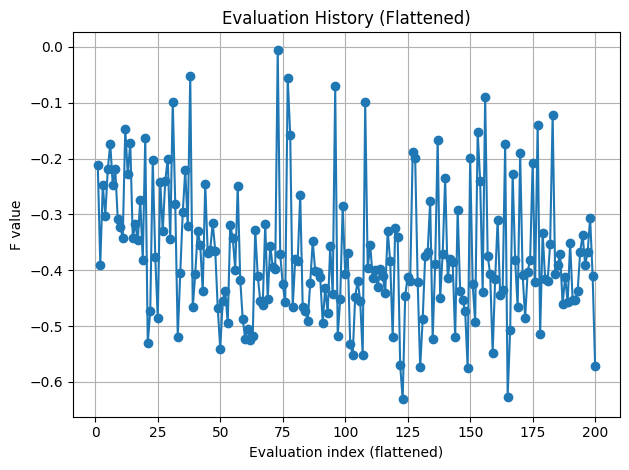

In [40]:
# Flatten the provided evaluation history into a 1D vector and plot it.
import matplotlib.pyplot as plt
import pandas as pd
                        

# Flatten to 1D list
flat = [v for row in evaluation_history for v in row]



# Plot
plt.figure()
plt.plot(range(1, len(flat)+1), flat, marker='o')
plt.xlabel("Evaluation index (flattened)")
plt.ylabel("F value")
plt.title("Evaluation History (Flattened)")
plt.grid(True)
plt.tight_layout()
plt.show()

